# The "Trump Effect" Dataset

Obiettivo di questa analisi è studiare l'orientamento politico della popolazione di alcuni stati europei in base a diversi fattori analizzando i risultati di un sondaggio condotto dall'agenzia <a href="https://daliaresearch.com/">Dalia</a> successivamente alle elezioni di Donald Trump nel 2016. 

In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
from collections import Counter
import scipy.stats as ss

In [491]:
%matplotlib inline

In [492]:
data = pd.read_csv("./archive/plaintext_csv/data_e28.csv - data_e28.csv.csv")

C:\Users\giord\miniconda3\envs\mwt\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (42,45,46,47,48,49,50,51,52,55,56,58,59,60,61,63) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Esplorazione preliminare e data cleaning

In [493]:
data.head()

,[meta] uuid,[meta] weight,[dem] country_code,[dem] age,[dem] gender,[dem] education_level,[dem] degree_of_urbanisation,[dem] residency,[dem] household_size,[dem] immigration,...,[question] international_trade_gain_or_loss,[question] country_comes_first,[question] improving_life_by_hardwork,[question] conspiracy,[question] government_controlled_by_elite,[question] trust_in_own_judgment,[question] perceived_effect_of_diversity,[question] gender_discrimination_importance,[question] family_friends_highereducation,[question] worldview
0,aa552c00-9d49-0134-4b90-0aaafcbd6b1f,1.204608,AT,23,male,I completed high school or obtained an equival...,rural,"Yes, as a citizen",3,One or both of my parents moved here before I ...,...,… gains a lot,Somewhat agree,Strongly agree,Somewhat disagree,Neither agree nor disagree,Somewhat disagree,Somewhat positively,"Yes, somewhat",Most of them,"It's a big, beautiful world, mostly full of go..."
1,5c8c8820-a041-0134-7ae8-0aaafcbd6b1f,1.334641,AT,45,male,I have completed a university or equivalent de...,city,"Yes, as a citizen",3,My family has been here for a longer time,...,… neither gains nor loses,Somewhat agree,Strongly agree,Strongly agree,Somewhat agree,Strongly agree,Neither positively nor negatively,"Yes, very",Most of them,"Our lives are threatened by terrorists, crimin..."
2,11cc2fc0-9f89-0134-a13e-0aaafcbd6b1f,2.750283,AT,47,male,I completed high school or obtained an equival...,rural,"Yes, as a citizen",5 or more,One or both of my parents moved here before I ...,...,… gains a lot,Strongly agree,Somewhat agree,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,Neither positively nor negatively,"Yes, very",Don't know,"Our lives are threatened by terrorists, crimin..."
3,fa3a8ed0-9d58-0134-af7b-0aaafcbd6b1f,0.503159,AT,15,male,I have some high school or secondary school ed...,rural,"Yes, as a citizen",5 or more,My family has been here for a longer time,...,… neither gains nor loses,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat negatively,"Yes, very",About half,"It's a big, beautiful world, mostly full of go..."
4,026e16e0-9d49-0134-47be-0aaafcbd6b1f,0.769498,AT,48,female,I have some high school or secondary school ed...,rural,"Yes, as a citizen",3,My family has been here for a longer time,...,… gains a lot,Somewhat agree,Strongly agree,Somewhat disagree,Somewhat agree,Somewhat agree,Somewhat positively,"Yes, somewhat",About half,"It's a big, beautiful world, mostly full of go..."


In [494]:
data.shape

(11283, 90)

In [495]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11283 entries, 0 to 11282
Data columns (total 90 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   [meta] uuid                                          11283 non-null  object 
 1   [meta] weight                                        11283 non-null  float64
 2   [dem] country_code                                   11283 non-null  object 
 3   [dem] age                                            11283 non-null  int64  
 4   [dem] gender                                         11283 non-null  object 
 5   [dem] education_level                                11283 non-null  object 
 6   [dem] degree_of_urbanisation                         11283 non-null  object 
 7   [dem] residency                                      11283 non-null  object 
 8   [dem] household_size                                 11087 non-nul

Il sondaggio è stato quindi sottoposto a 11283 individui a cui sono state sottoposte 88 domande (i primi due campi del dataset sono metadati).

Rinominiamo le colonne per renderle più leggibili

In [496]:
data.rename(columns = lambda c: c[c.find("]")+1:].replace("_", " ").upper().strip(), inplace=True)

In [497]:
data.head()

,UUID,WEIGHT,COUNTRY CODE,AGE,GENDER,EDUCATION LEVEL,DEGREE OF URBANISATION,RESIDENCY,HOUSEHOLD SIZE,IMMIGRATION,...,INTERNATIONAL TRADE GAIN OR LOSS,COUNTRY COMES FIRST,IMPROVING LIFE BY HARDWORK,CONSPIRACY,GOVERNMENT CONTROLLED BY ELITE,TRUST IN OWN JUDGMENT,PERCEIVED EFFECT OF DIVERSITY,GENDER DISCRIMINATION IMPORTANCE,FAMILY FRIENDS HIGHEREDUCATION,WORLDVIEW
0,aa552c00-9d49-0134-4b90-0aaafcbd6b1f,1.204608,AT,23,male,I completed high school or obtained an equival...,rural,"Yes, as a citizen",3,One or both of my parents moved here before I ...,...,… gains a lot,Somewhat agree,Strongly agree,Somewhat disagree,Neither agree nor disagree,Somewhat disagree,Somewhat positively,"Yes, somewhat",Most of them,"It's a big, beautiful world, mostly full of go..."
1,5c8c8820-a041-0134-7ae8-0aaafcbd6b1f,1.334641,AT,45,male,I have completed a university or equivalent de...,city,"Yes, as a citizen",3,My family has been here for a longer time,...,… neither gains nor loses,Somewhat agree,Strongly agree,Strongly agree,Somewhat agree,Strongly agree,Neither positively nor negatively,"Yes, very",Most of them,"Our lives are threatened by terrorists, crimin..."
2,11cc2fc0-9f89-0134-a13e-0aaafcbd6b1f,2.750283,AT,47,male,I completed high school or obtained an equival...,rural,"Yes, as a citizen",5 or more,One or both of my parents moved here before I ...,...,… gains a lot,Strongly agree,Somewhat agree,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,Neither positively nor negatively,"Yes, very",Don't know,"Our lives are threatened by terrorists, crimin..."
3,fa3a8ed0-9d58-0134-af7b-0aaafcbd6b1f,0.503159,AT,15,male,I have some high school or secondary school ed...,rural,"Yes, as a citizen",5 or more,My family has been here for a longer time,...,… neither gains nor loses,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat negatively,"Yes, very",About half,"It's a big, beautiful world, mostly full of go..."
4,026e16e0-9d49-0134-47be-0aaafcbd6b1f,0.769498,AT,48,female,I have some high school or secondary school ed...,rural,"Yes, as a citizen",3,My family has been here for a longer time,...,… gains a lot,Somewhat agree,Strongly agree,Somewhat disagree,Somewhat agree,Somewhat agree,Somewhat positively,"Yes, somewhat",About half,"It's a big, beautiful world, mostly full of go..."


Utilizziamo la prima colonna come indice del nostro dataset ed eliminiamo la seconda che non sarà utile per la nostra analisi:

In [498]:
data.set_index(data.columns[0], inplace=True, verify_integrity=True)
data.drop(data.columns[0], axis=1, inplace=True)

In [499]:
data.head()

,COUNTRY CODE,AGE,GENDER,EDUCATION LEVEL,DEGREE OF URBANISATION,RESIDENCY,HOUSEHOLD SIZE,IMMIGRATION,ORIGIN,SETTLEMENT SIZE,...,INTERNATIONAL TRADE GAIN OR LOSS,COUNTRY COMES FIRST,IMPROVING LIFE BY HARDWORK,CONSPIRACY,GOVERNMENT CONTROLLED BY ELITE,TRUST IN OWN JUDGMENT,PERCEIVED EFFECT OF DIVERSITY,GENDER DISCRIMINATION IMPORTANCE,FAMILY FRIENDS HIGHEREDUCATION,WORLDVIEW
UUID,,,,,,,,,,,,,,,,,,,,,
aa552c00-9d49-0134-4b90-0aaafcbd6b1f,AT,23,male,I completed high school or obtained an equival...,rural,"Yes, as a citizen",3,One or both of my parents moved here before I ...,"Western, Southern or Northern Europe",Town with 1 000 - 50 000 people,...,… gains a lot,Somewhat agree,Strongly agree,Somewhat disagree,Neither agree nor disagree,Somewhat disagree,Somewhat positively,"Yes, somewhat",Most of them,"It's a big, beautiful world, mostly full of go..."
5c8c8820-a041-0134-7ae8-0aaafcbd6b1f,AT,45,male,I have completed a university or equivalent de...,city,"Yes, as a citizen",3,My family has been here for a longer time,NaN,City with 1 million - 5 million people,...,… neither gains nor loses,Somewhat agree,Strongly agree,Strongly agree,Somewhat agree,Strongly agree,Neither positively nor negatively,"Yes, very",Most of them,"Our lives are threatened by terrorists, crimin..."
11cc2fc0-9f89-0134-a13e-0aaafcbd6b1f,AT,47,male,I completed high school or obtained an equival...,rural,"Yes, as a citizen",5 or more,One or both of my parents moved here before I ...,Other,Town with 1 000 - 50 000 people,...,… gains a lot,Strongly agree,Somewhat agree,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,Neither positively nor negatively,"Yes, very",Don't know,"Our lives are threatened by terrorists, crimin..."
fa3a8ed0-9d58-0134-af7b-0aaafcbd6b1f,AT,15,male,I have some high school or secondary school ed...,rural,"Yes, as a citizen",5 or more,My family has been here for a longer time,NaN,Town with fewer than 1 000 people,...,… neither gains nor loses,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat negatively,"Yes, very",About half,"It's a big, beautiful world, mostly full of go..."
026e16e0-9d49-0134-47be-0aaafcbd6b1f,AT,48,female,I have some high school or secondary school ed...,rural,"Yes, as a citizen",3,My family has been here for a longer time,NaN,Town with 1 000 - 50 000 people,...,… gains a lot,Somewhat agree,Strongly agree,Somewhat disagree,Somewhat agree,Somewhat agree,Somewhat positively,"Yes, somewhat",About half,"It's a big, beautiful world, mostly full of go..."


### Gestione valori mancanti e pulizia del dataset

In [500]:
data.isnull().any()

COUNTRY CODE                        False
AGE                                 False
GENDER                              False
EDUCATION LEVEL                     False
DEGREE OF URBANISATION              False
                                    ...  
TRUST IN OWN JUDGMENT               False
PERCEIVED EFFECT OF DIVERSITY       False
GENDER DISCRIMINATION IMPORTANCE    False
FAMILY FRIENDS HIGHEREDUCATION      False
WORLDVIEW                           False
Length: 88, dtype: bool

In [501]:
data.isnull().any()[data.isnull().any() == True]

HOUSEHOLD SIZE                              True
ORIGIN                                      True
EMPLOYMENT STATUS IN EDUCATION              True
SOCIAL NETWORKS REGULARLY USED              True
SOCIAL MEDIA ACTIVITY RANK                  True
ONLINE SHARING FREQUENCY                    True
SHARING NETWORK SIZE                        True
MEMBER ORGANIZATION                         True
ORGANIZATION ACTIVITIES TIMEPERWEEK         True
MEDIA TV HOURS                              True
MEDIA RADIO HOURS                           True
MEDIA PRINT HOURS                           True
VOTE REFERENDUM                             True
FREQUENCY OF VOTING                         True
VOTE NEXT NATIONAL ELECTION                 True
RANKING PARTY DE                            True
VOTED PARTY LAST ELECTION DE                True
RANKING PARTY FR                            True
VOTED PARTY LAST ELECTION FR                True
RANKING PARTY ES                            True
VOTED PARTY LAST ELE

In [502]:
data.isnull().all()[data.isnull().all() == True]

Series([], dtype: bool)

Molte colonne del dataset presentano valuri nulli, ma nessuna colonna ha solamente valori nulli.

In [503]:
null_columns = data.isnull().any()[data.isnull().any() == True]
data[null_columns.index]

,HOUSEHOLD SIZE,ORIGIN,EMPLOYMENT STATUS IN EDUCATION,SOCIAL NETWORKS REGULARLY USED,SOCIAL MEDIA ACTIVITY RANK,ONLINE SHARING FREQUENCY,SHARING NETWORK SIZE,MEMBER ORGANIZATION,ORGANIZATION ACTIVITIES TIMEPERWEEK,MEDIA TV HOURS,...,VOTE NEXTELECTION PL,VOTE NEXTELECTION IT,VOTE NEXTELECTION GB,CERTAINTY PARTY TO VOTE,FRIENDS FAMILY SAME VOTE,IMPORTANT ISSUES WHEN VOTING,RANKING IMPORTANCE OF ISSUES WHEN VOTING,PREFERRED TYPE OF POLITICAL LEADER,FREQUENT SHARING OF POLITICALVIEWS,HOMETOWN CHANGE PAST5YEARS
UUID,,,,,,,,,,,,,,,,,,,,,
aa552c00-9d49-0134-4b90-0aaafcbd6b1f,3,"Western, Southern or Northern Europe","...not employed, currently looking for work",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5c8c8820-a041-0134-7ae8-0aaafcbd6b1f,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Much worse
11cc2fc0-9f89-0134-a13e-0aaafcbd6b1f,5 or more,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fa3a8ed0-9d58-0134-af7b-0aaafcbd6b1f,5 or more,NaN,"...not employed, currently NOT looking for work",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat better
026e16e0-9d49-0134-47be-0aaafcbd6b1f,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat better
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545ed0e0-9e7a-0134-f5e3-0aaafcbd6b1f,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8e805be0-a11b-0134-41ae-0a62e1402143,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat better
089c3110-9df1-0134-4a6f-0aaafcbd6b1f,4,NaN,...employed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Much better


Da una prima osservazione sembra che alcune colonne abbiano molti valori nulli. Per verificare questo contiamo per ogni colonna la percentuale di valori nulli rispetto al totale.

In [504]:
nullData = (data[null_columns.index].isnull().sum()/11283)*100
nullData.sort_values(ascending=True, inplace=True)

In [505]:
nullData

HOUSEHOLD SIZE                               1.737127
VOTE NEXT NATIONAL ELECTION                 28.378977
FREQUENCY OF VOTING                         28.378977
MEDIA PRINT HOURS                           28.378977
MEDIA RADIO HOURS                           28.378977
MEDIA TV HOURS                              28.378977
MEMBER ORGANIZATION                         28.378977
IMPORTANT ISSUES WHEN VOTING                28.378977
SOCIAL NETWORKS REGULARLY USED              28.378977
PREFERRED TYPE OF POLITICAL LEADER          28.378977
FREQUENT SHARING OF POLITICALVIEWS          28.378977
ONLINE SHARING FREQUENCY                    30.940353
SOCIAL MEDIA ACTIVITY RANK                  30.940353
RANKING IMPORTANCE OF ISSUES WHEN VOTING    34.724807
SHARING NETWORK SIZE                        35.885846
CERTAINTY PARTY TO VOTE                     39.457591
FRIENDS FAMILY SAME VOTE                    39.457591
HOMETOWN CHANGE PAST5YEARS                  40.964283
WHEN VOTE DECISION WAS MADE 

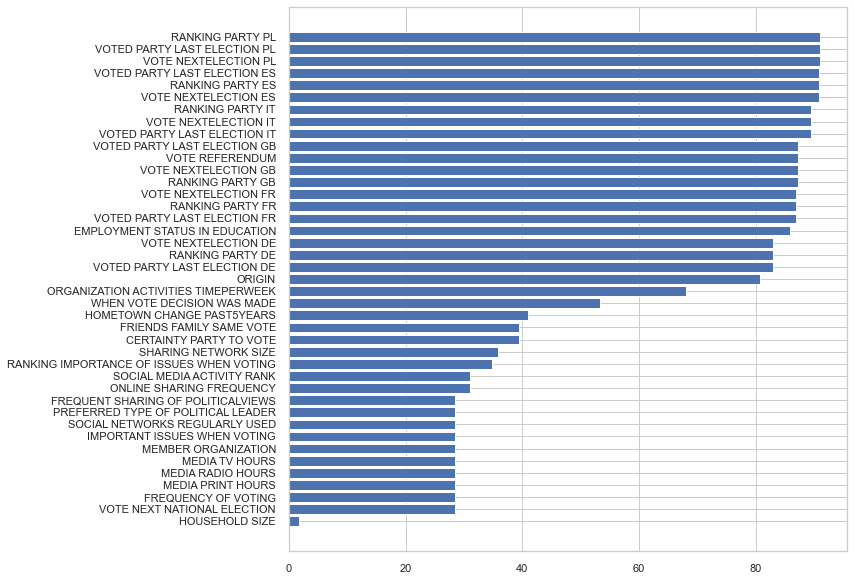

In [506]:
fig, ax = plt.subplots()
ax.barh(nullData.index, nullData.values)
ax.grid(True, axis='x')
fig.set_size_inches(10,10)

Selezioniamo le colonne con più del 40% di dati nulli.

In [507]:
mostNullColumns = nullData[nullData.values>40]

In [508]:
mostNullColumns

HOMETOWN CHANGE PAST5YEARS             40.964283
WHEN VOTE DECISION WAS MADE            53.310290
ORGANIZATION ACTIVITIES TIMEPERWEEK    68.058141
ORIGIN                                 80.758663
VOTED PARTY LAST ELECTION DE           82.921209
RANKING PARTY DE                       82.921209
VOTE NEXTELECTION DE                   82.921209
EMPLOYMENT STATUS IN EDUCATION         85.854826
VOTED PARTY LAST ELECTION FR           86.944961
RANKING PARTY FR                       86.944961
VOTE NEXTELECTION FR                   86.944961
RANKING PARTY GB                       87.228574
VOTE NEXTELECTION GB                   87.228574
VOTE REFERENDUM                        87.228574
VOTED PARTY LAST ELECTION GB           87.228574
VOTED PARTY LAST ELECTION IT           89.391119
VOTE NEXTELECTION IT                   89.391119
RANKING PARTY IT                       89.391119
VOTE NEXTELECTION ES                   90.844634
RANKING PARTY ES                       90.844634
VOTED PARTY LAST ELE

In [509]:
len(mostNullColumns)

24

Osservando le colonne notiamo come alcune siano relative ad elezioni in paesi specifici (Italia, Germania, ecc..) quindi probabilmente sono state compilate solo da persone residenti in quei determinati paesi. 

Osserviamo questi campi e valutiamo se possono essere aggregati in un'unica colonna.

In [510]:
data['VOTED PARTY LAST ELECTION IT'].unique()

array([nan, 'Yes, I voted for M5S - Movimento 5 Stelle',
       "I wanted to vote but I wasn't able to",
       'Yes, but I voted for another party',
       'Yes, I voted for Forza Italia',
       'Yes, I voted for NCD - Nuovo Centrodestra',
       'Yes, I voted for SEL - Sinistra Ecologia Libertà',
       'Yes, I voted for PD - Partito Democratico', 'No, I did not vote',
       'Yes, I voted for LN - Lega Nord',
       'Yes, I voted for SC - Scelta Civica',
       "Yes, I voted for FdI - AN - Fratelli d'Italia – Alleanza Nazionale",
       'Yes, I voted for CR - Conservatori e Riformisti',
       'Yes, I voted for ALA - Alleanza Liberalpopolare – Autonomie'],
      dtype=object)

In [511]:
data[['VOTED PARTY LAST ELECTION IT', 'VOTED PARTY LAST ELECTION DE']][data['COUNTRY CODE'] == 'IT']

,VOTED PARTY LAST ELECTION IT,VOTED PARTY LAST ELECTION DE
UUID,,
221edec0-9d67-0134-e688-0aaafcbd6b1f,"Yes, I voted for M5S - Movimento 5 Stelle",NaN
84563570-9d65-0134-f897-0a62e1402143,I wanted to vote but I wasn't able to,NaN
5d273aa0-9dd8-0134-4ee2-0aaafcbd6b1f,I wanted to vote but I wasn't able to,NaN
8c81c4e0-a2a3-0134-095c-0aaafcbd6b1f,I wanted to vote but I wasn't able to,NaN
ed6e79f0-9d6d-0134-951e-0a62e1402143,"Yes, I voted for M5S - Movimento 5 Stelle",NaN
...,...,...
ac007090-9fa1-0134-d1eb-0aaafcbd6b1f,"Yes, but I voted for another party",NaN
fa5244f0-9e08-0134-80d1-0a62e1402143,"No, I did not vote",NaN
26d2f690-9e0a-0134-214e-0aaafcbd6b1f,"Yes, I voted for CR - Conservatori e Riformisti",NaN


In [512]:
data['VOTED PARTY LAST ELECTION IT'][data['COUNTRY CODE'] == 'IT'].isnull().any()

False

In [513]:
data['VOTED PARTY LAST ELECTION DE'][data['COUNTRY CODE'] == 'DE'].isnull().any()

False

In [514]:
data['VOTED PARTY LAST ELECTION FR'][data['COUNTRY CODE'] == 'FR'].isnull().any()

False

In [515]:
data['VOTED PARTY LAST ELECTION GB'][data['COUNTRY CODE'] == 'GB'].isnull().any()

False

In [516]:
data['VOTED PARTY LAST ELECTION ES'][data['COUNTRY CODE'] == 'ES'].isnull().any()

False

In [517]:
data['VOTED PARTY LAST ELECTION PL'][data['COUNTRY CODE'] == 'PL'].isnull().any()

False

Quindi nessuna di queste colonne ha valori nulli per campioni dello stesso paese. Dalla percentuale di valori nulli possiamo assumere che anche per le altre colonne relative alle elezioni (_RANKING PARTY_ e _VOTE NEXTELECTION_) nei singoli paesi non ci siano valori nulli per i rispondenti di quei paesi. 

Creiamo una nuova colonna che aggrega le informazioni presenti per i singoli paesi.

In [518]:
voted = data['VOTED PARTY LAST ELECTION DE'][data['COUNTRY CODE'] == 'DE']\
.append(data['VOTED PARTY LAST ELECTION IT'][data['COUNTRY CODE'] == 'IT'])\
.append(data['VOTED PARTY LAST ELECTION FR'][data['COUNTRY CODE'] == 'FR'])\
.append(data['VOTED PARTY LAST ELECTION GB'][data['COUNTRY CODE'] == 'GB'])\
.append(data['VOTED PARTY LAST ELECTION ES'][data['COUNTRY CODE'] == 'ES'])\
.append(data['VOTED PARTY LAST ELECTION PL'][data['COUNTRY CODE'] == 'PL'])

In [519]:
voted.isnull().any()

False

In [520]:
voted

UUID
c8051460-a0fa-0134-e47f-0aaafcbd6b1f                           Yes, I voted for Die Linke
6bbef710-a060-0134-8ddc-0aaafcbd6b1f    Yes, I voted for CDU/CSU – Christlich Demokrat...
1d72cbd0-9f53-0134-0d5d-0aaafcbd6b1f                I wanted to vote but I wasn't able to
f90f8c20-9e95-0134-cceb-0a62e1402143    Yes, I voted for CDU/CSU – Christlich Demokrat...
4106d1c0-9d60-0134-b693-0a62e1402143    Yes, I voted for SPD – Sozialdemokratische Par...
                                                              ...                        
c5a684c0-9e8c-0134-0660-0aaafcbd6b1f          Yes, I voted for PO - Platforma Obywatelska
56475270-a21a-0134-a736-0a62e1402143                   Yes, I voted for PR - Polska Razem
bc700b00-9e2a-0134-f41f-0a62e1402143                                   No, I did not vote
4b8c2ad0-9d62-0134-e271-0aaafcbd6b1f                I wanted to vote but I wasn't able to
b50a1130-9d42-0134-98d3-0a62e1402143                    Yes, I voted for .N - .Nowoczesna
Lengt

Ripetiamo la procedura anche per le altre colonne:

In [521]:
rankingParty = data['RANKING PARTY DE'][data['COUNTRY CODE'] == 'DE']\
.append(data['RANKING PARTY IT'][data['COUNTRY CODE'] == 'IT'])\
.append(data['RANKING PARTY FR'][data['COUNTRY CODE'] == 'FR'])\
.append(data['RANKING PARTY GB'][data['COUNTRY CODE'] == 'GB'])\
.append(data['RANKING PARTY ES'][data['COUNTRY CODE'] == 'ES'])\
.append(data['RANKING PARTY PL'][data['COUNTRY CODE'] == 'PL'])

In [522]:
rankingParty

UUID
c8051460-a0fa-0134-e47f-0aaafcbd6b1f    Die Linke | SPD – Sozialdemokratische Partei D...
6bbef710-a060-0134-8ddc-0aaafcbd6b1f    CDU/CSU – Christlich Demokratische Union/Chris...
1d72cbd0-9f53-0134-0d5d-0aaafcbd6b1f    CDU/CSU – Christlich Demokratische Union/Chris...
f90f8c20-9e95-0134-cceb-0a62e1402143    CDU/CSU – Christlich Demokratische Union/Chris...
4106d1c0-9d60-0134-b693-0a62e1402143    SPD – Sozialdemokratische Partei Deutschlands ...
                                                              ...                        
c5a684c0-9e8c-0134-0660-0aaafcbd6b1f    PO - Platforma Obywatelska | .N - .Nowoczesna ...
56475270-a21a-0134-a736-0a62e1402143    Kukiz'15 | SP - Solidarna Polska | PiS - Prawo...
bc700b00-9e2a-0134-f41f-0a62e1402143    .N - .Nowoczesna | PR - Polska Razem | SP - So...
4b8c2ad0-9d62-0134-e271-0aaafcbd6b1f    PR - Polska Razem | Kukiz'15 | .N - .Nowoczesn...
b50a1130-9d42-0134-98d3-0a62e1402143    PO - Platforma Obywatelska | PSL - Polskie Str...
Lengt

In [523]:
rankingParty.isnull().any()

False

In [524]:
voteNextElection = pd.concat([data['VOTE NEXTELECTION DE'][data['COUNTRY CODE'] == 'DE'],
                                data['VOTE NEXTELECTION IT'][data['COUNTRY CODE'] == 'IT'],
                                data['VOTE NEXTELECTION FR'][data['COUNTRY CODE'] == 'FR'],
                                data['VOTE NEXTELECTION GB'][data['COUNTRY CODE'] == 'GB'],
                                data['VOTE NEXTELECTION ES'][data['COUNTRY CODE'] == 'ES'],
                                data['VOTE NEXTELECTION PL'][data['COUNTRY CODE'] == 'PL']], verify_integrity=True)

In [525]:
voteNextElection

UUID
c8051460-a0fa-0134-e47f-0aaafcbd6b1f                                            Die Linke
6bbef710-a060-0134-8ddc-0aaafcbd6b1f                                     I would not vote
1d72cbd0-9f53-0134-0d5d-0aaafcbd6b1f        SPD – Sozialdemokratische Partei Deutschlands
f90f8c20-9e95-0134-cceb-0a62e1402143    CDU/CSU – Christlich Demokratische Union/Chris...
4106d1c0-9d60-0134-b693-0a62e1402143        SPD – Sozialdemokratische Partei Deutschlands
                                                              ...                        
c5a684c0-9e8c-0134-0660-0aaafcbd6b1f                           PO - Platforma Obywatelska
56475270-a21a-0134-a736-0a62e1402143                                             Kukiz'15
bc700b00-9e2a-0134-f41f-0a62e1402143                                     .N - .Nowoczesna
4b8c2ad0-9d62-0134-e271-0aaafcbd6b1f                                                Other
b50a1130-9d42-0134-98d3-0a62e1402143                           PO - Platforma Obywatelska
Lengt

In [526]:
voteNextElection.isnull().any()

False

Aggiungiamo queste nuove colonne al dataset ed eliminiamo le precedenti:

In [527]:
data['VOTED PARTY LAST ELECTION'] = voted
data['RANKING PARTY'] = rankingParty
data['VOTE NEXT ELECTION'] = voteNextElection

In [528]:
data.drop(['VOTED PARTY LAST ELECTION DE', 'VOTED PARTY LAST ELECTION IT', 'VOTED PARTY LAST ELECTION FR',
           'VOTED PARTY LAST ELECTION GB', 'VOTED PARTY LAST ELECTION ES', 'VOTED PARTY LAST ELECTION PL',
           'RANKING PARTY DE', 'RANKING PARTY IT', 'RANKING PARTY FR', 'RANKING PARTY GB', 'RANKING PARTY ES', 
           'RANKING PARTY PL', 'VOTE NEXTELECTION DE', 'VOTE NEXTELECTION IT', 'VOTE NEXTELECTION FR', 'VOTE NEXTELECTION GB',
           'VOTE NEXTELECTION ES', 'VOTE NEXTELECTION PL'], axis=1, inplace=True)

In [529]:
data.head()

,COUNTRY CODE,AGE,GENDER,EDUCATION LEVEL,DEGREE OF URBANISATION,RESIDENCY,HOUSEHOLD SIZE,IMMIGRATION,ORIGIN,SETTLEMENT SIZE,...,CONSPIRACY,GOVERNMENT CONTROLLED BY ELITE,TRUST IN OWN JUDGMENT,PERCEIVED EFFECT OF DIVERSITY,GENDER DISCRIMINATION IMPORTANCE,FAMILY FRIENDS HIGHEREDUCATION,WORLDVIEW,VOTED PARTY LAST ELECTION,RANKING PARTY,VOTE NEXT ELECTION
UUID,,,,,,,,,,,,,,,,,,,,,
aa552c00-9d49-0134-4b90-0aaafcbd6b1f,AT,23,male,I completed high school or obtained an equival...,rural,"Yes, as a citizen",3,One or both of my parents moved here before I ...,"Western, Southern or Northern Europe",Town with 1 000 - 50 000 people,...,Somewhat disagree,Neither agree nor disagree,Somewhat disagree,Somewhat positively,"Yes, somewhat",Most of them,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN
5c8c8820-a041-0134-7ae8-0aaafcbd6b1f,AT,45,male,I have completed a university or equivalent de...,city,"Yes, as a citizen",3,My family has been here for a longer time,NaN,City with 1 million - 5 million people,...,Strongly agree,Somewhat agree,Strongly agree,Neither positively nor negatively,"Yes, very",Most of them,"Our lives are threatened by terrorists, crimin...",NaN,NaN,NaN
11cc2fc0-9f89-0134-a13e-0aaafcbd6b1f,AT,47,male,I completed high school or obtained an equival...,rural,"Yes, as a citizen",5 or more,One or both of my parents moved here before I ...,Other,Town with 1 000 - 50 000 people,...,Neither agree nor disagree,Somewhat agree,Neither agree nor disagree,Neither positively nor negatively,"Yes, very",Don't know,"Our lives are threatened by terrorists, crimin...",NaN,NaN,NaN
fa3a8ed0-9d58-0134-af7b-0aaafcbd6b1f,AT,15,male,I have some high school or secondary school ed...,rural,"Yes, as a citizen",5 or more,My family has been here for a longer time,NaN,Town with fewer than 1 000 people,...,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat negatively,"Yes, very",About half,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN
026e16e0-9d49-0134-47be-0aaafcbd6b1f,AT,48,female,I have some high school or secondary school ed...,rural,"Yes, as a citizen",3,My family has been here for a longer time,NaN,Town with 1 000 - 50 000 people,...,Somewhat disagree,Somewhat agree,Somewhat agree,Somewhat positively,"Yes, somewhat",About half,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN


In [530]:
data[['VOTED PARTY LAST ELECTION', 'RANKING PARTY', 'VOTE NEXT ELECTION']][data['VOTED PARTY LAST ELECTION'].notnull()]

,VOTED PARTY LAST ELECTION,RANKING PARTY,VOTE NEXT ELECTION
UUID,,,
c8051460-a0fa-0134-e47f-0aaafcbd6b1f,"Yes, I voted for Die Linke",Die Linke | SPD – Sozialdemokratische Partei D...,Die Linke
6bbef710-a060-0134-8ddc-0aaafcbd6b1f,"Yes, I voted for CDU/CSU – Christlich Demokrat...",CDU/CSU – Christlich Demokratische Union/Chris...,I would not vote
1d72cbd0-9f53-0134-0d5d-0aaafcbd6b1f,I wanted to vote but I wasn't able to,CDU/CSU – Christlich Demokratische Union/Chris...,SPD – Sozialdemokratische Partei Deutschlands
f90f8c20-9e95-0134-cceb-0a62e1402143,"Yes, I voted for CDU/CSU – Christlich Demokrat...",CDU/CSU – Christlich Demokratische Union/Chris...,CDU/CSU – Christlich Demokratische Union/Chris...
4106d1c0-9d60-0134-b693-0a62e1402143,"Yes, I voted for SPD – Sozialdemokratische Par...",SPD – Sozialdemokratische Partei Deutschlands ...,SPD – Sozialdemokratische Partei Deutschlands
...,...,...,...
c5a684c0-9e8c-0134-0660-0aaafcbd6b1f,"Yes, I voted for PO - Platforma Obywatelska",PO - Platforma Obywatelska | .N - .Nowoczesna ...,PO - Platforma Obywatelska
56475270-a21a-0134-a736-0a62e1402143,"Yes, I voted for PR - Polska Razem",Kukiz'15 | SP - Solidarna Polska | PiS - Prawo...,Kukiz'15
bc700b00-9e2a-0134-f41f-0a62e1402143,"No, I did not vote",.N - .Nowoczesna | PR - Polska Razem | SP - So...,.N - .Nowoczesna


In [531]:
data.shape

(11283, 73)

Ricalcoliamo ora la percentuale di valori nulli con questi nuovi campi ed i campi che superano il 40% di dati nulli:

In [532]:
null_columns = data.isnull().any()[data.isnull().any() == True]

nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)

nullData

HOUSEHOLD SIZE                               1.737127
VOTED PARTY LAST ELECTION                   28.378977
FREQUENT SHARING OF POLITICALVIEWS          28.378977
PREFERRED TYPE OF POLITICAL LEADER          28.378977
IMPORTANT ISSUES WHEN VOTING                28.378977
VOTE NEXT NATIONAL ELECTION                 28.378977
FREQUENCY OF VOTING                         28.378977
RANKING PARTY                               28.378977
MEDIA PRINT HOURS                           28.378977
MEDIA RADIO HOURS                           28.378977
VOTE NEXT ELECTION                          28.378977
MEMBER ORGANIZATION                         28.378977
SOCIAL NETWORKS REGULARLY USED              28.378977
MEDIA TV HOURS                              28.378977
ONLINE SHARING FREQUENCY                    30.940353
SOCIAL MEDIA ACTIVITY RANK                  30.940353
RANKING IMPORTANCE OF ISSUES WHEN VOTING    34.724807
SHARING NETWORK SIZE                        35.885846
CERTAINTY PARTY TO VOTE     

In [533]:
mostNullColumns = nullData[nullData.values>40]
mostNullColumns

HOMETOWN CHANGE PAST5YEARS             40.964283
WHEN VOTE DECISION WAS MADE            53.310290
ORGANIZATION ACTIVITIES TIMEPERWEEK    68.058141
ORIGIN                                 80.758663
EMPLOYMENT STATUS IN EDUCATION         85.854826
VOTE REFERENDUM                        87.228574
dtype: float64

Osserviamo i valori assunti dalla colonna _VOTE REFERENDUM_ e vediamo se possiamo trarre qualche informazione:

In [534]:
data['VOTE REFERENDUM'].unique()

array([nan, 'I did not vote', 'For the UK to stay in the EU',
       'For the UK to leave the EU'], dtype=object)

In [535]:
data['VOTE REFERENDUM'][data['COUNTRY CODE'] == 'GB']

UUID
96d27400-9fb5-0134-455f-0a62e1402143                  I did not vote
f5412a70-a123-0134-cf5c-0aaafcbd6b1f                  I did not vote
e1d6e790-a1d8-0134-777b-0a62e1402143    For the UK to stay in the EU
93a79c40-a05b-0134-bb1f-0aaafcbd6b1f                  I did not vote
8871fa70-a080-0134-f22d-0aaafcbd6b1f      For the UK to leave the EU
                                                    ...             
3748f990-a081-0134-b04e-0a62e1402143    For the UK to stay in the EU
adbc8080-9e13-0134-ca62-0aaafcbd6b1f    For the UK to stay in the EU
957aaac0-a04f-0134-2661-0aaafcbd6b1f                  I did not vote
de8a0c60-a081-0134-0a8d-0aaafcbd6b1f    For the UK to stay in the EU
63cc65f0-9e17-0134-b280-0a62e1402143                  I did not vote
Name: VOTE REFERENDUM, Length: 1441, dtype: object

In [536]:
data['VOTE REFERENDUM'][data['COUNTRY CODE'] == 'GB'].isnull().any()

False

Quindi la colonna _VOTE REFERENDUM_ è relativa al referendum per l'uscita della Gran Bretagna dall'Unione Europea ed è stata risposta solo dai residenti in Gran Bretagna. Scegliamo di rimuovere questa colonna dal momento che è relativa solo ad un sotto campione della nostra popolazione, mentre la nostra analisi sarà relativa all'intera popolazione che ha risposto al sondaggio.

In [537]:
data.drop('VOTE REFERENDUM', axis = 1, inplace=True)

In [538]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
mostNullColumns = nullData[nullData.values>40]
mostNullColumns

HOMETOWN CHANGE PAST5YEARS             40.964283
WHEN VOTE DECISION WAS MADE            53.310290
ORGANIZATION ACTIVITIES TIMEPERWEEK    68.058141
ORIGIN                                 80.758663
EMPLOYMENT STATUS IN EDUCATION         85.854826
dtype: float64

Osserviamo ora la colonna _EMPLOYMENT STATUS IN EDUCATION_:

In [539]:
data['EMPLOYMENT STATUS IN EDUCATION'].unique()

array(['...not employed, currently looking for work', nan,
       '...not employed, currently NOT looking for work', '...employed'],
      dtype=object)

In [540]:
data['EMPLOYMENT STATUS IN EDUCATION'].notnull().sum()

1596

Osserviamo se vi sia qualche correlazione tra la mancanza di risposte in questo campo e la nostra variabile dipende:

In [541]:
data['POLITICAL VIEW'][data['EMPLOYMENT STATUS IN EDUCATION'].isnull()].value_counts()

Center right     3009
Center left      2874
Left             1527
Right            1456
Extreme right     488
Extreme left      333
Name: POLITICAL VIEW, dtype: int64

Non c'è una valore prevalente sugli altri quindi non possiamo trarre informazioni particolari informazioni da chi non ha risposto a questo campo. Scegliamo quindi di rimuoverlo. 

In [542]:
data.drop('EMPLOYMENT STATUS IN EDUCATION', axis=1, inplace=True)

In [543]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
mostNullColumns = nullData[nullData.values>40]
mostNullColumns

HOMETOWN CHANGE PAST5YEARS             40.964283
WHEN VOTE DECISION WAS MADE            53.310290
ORGANIZATION ACTIVITIES TIMEPERWEEK    68.058141
ORIGIN                                 80.758663
dtype: float64

Osserviamo ora la colonna _ORIGIN_:

In [544]:
data['ORIGIN'].unique()

array(['Western, Southern or Northern Europe', nan, 'Other',
       'Eastern Europe (includes Russia)', 'South America',
       'Middle East (includes Turkey) and North Africa',
       'Other | Western, Southern or Northern Europe', 'South-East Asia',
       'Central America (includes the Caribbean)',
       'South Asia (includes India)', 'East Asia (includes China)',
       'Sub-Saharan Africa', 'North America',
       'Middle East (includes Turkey) and North Africa | Sub-Saharan Africa',
       'Western, Southern or Northern Europe | Middle East (includes Turkey) and North Africa',
       'Central America (includes the Caribbean) | Western, Southern or Northern Europe',
       'Eastern Europe (includes Russia) | Middle East (includes Turkey) and North Africa',
       'Western, Southern or Northern Europe | Eastern Europe (includes Russia)',
       'South America | Middle East (includes Turkey) and North Africa',
       'Middle East (includes Turkey) and North Africa | Western, Southe

In [545]:
data['ORIGIN'].nunique()

66

In [546]:
data['ORIGIN'].isnull().sum()

9112

Il campo _ORIGIN_ aggrega all'interno una serie di sotto-valori che andrebbero divisi in campi univoci. Dal momento che questo farebbe aumentare notevolmente le dimensioni del dataset e che comunque contiene all'interno molti valori nulli scegliamo di rimuoverlo. 

Considereremo quindi nell'analisi solo persone la cui origine equivale al paese di residenza.

In [547]:
data.drop('ORIGIN', axis=1, inplace=True)

In [548]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
mostNullColumns = nullData[nullData.values>40]
mostNullColumns

HOMETOWN CHANGE PAST5YEARS             40.964283
WHEN VOTE DECISION WAS MADE            53.310290
ORGANIZATION ACTIVITIES TIMEPERWEEK    68.058141
dtype: float64

Analizziamo ora la colonna _ORGANIZATION ACTIVITIES TIMEPERWEEK_:

In [549]:
data['ORGANIZATION ACTIVITIES TIMEPERWEEK'].unique()

array([nan, '1 - 3 hours', '3 - 5 hours', 'Less than 1 hour',
       '5 - 10 hours', '10 - 20 hours', 'More than 20 hours'],
      dtype=object)

In [550]:
data['MEMBER ORGANIZATION'][data['ORGANIZATION ACTIVITIES TIMEPERWEEK'].notnull()]

UUID
c8051460-a0fa-0134-e47f-0aaafcbd6b1f                                      Political party
6bbef710-a060-0134-8ddc-0aaafcbd6b1f                                          Sports club
ef0bba10-9e02-0134-d0cb-0aaafcbd6b1f    Other type of club (music / art, entertainment...
2150c300-a1c0-0134-f003-0aaafcbd6b1f                                          Sports club
1da269f0-9eee-0134-c83f-0a62e1402143                Church or other religious institution
                                                              ...                        
5e0d9e70-a03f-0134-16b1-0aaafcbd6b1f    Other type of club (music / art, entertainment...
dbd53230-9dee-0134-e019-0aaafcbd6b1f    Other type of club (music / art, entertainment...
fa54ab70-9ee8-0134-e1a6-0a62e1402143                                          Sports club
4b8c2ad0-9d62-0134-e271-0aaafcbd6b1f    Other type of club (music / art, entertainment...
b50a1130-9d42-0134-98d3-0a62e1402143    Other type of club (music / art, entertainment...
Name:

In [551]:
data['MEMBER ORGANIZATION'][data['ORGANIZATION ACTIVITIES TIMEPERWEEK'].isnull()].isnull().all()

False

In [552]:
data['MEMBER ORGANIZATION'].unique()

array([nan, 'Political party', 'Sports club', 'None of the above',
       'Other type of club (music / art, entertainment, social work etc.)',
       'Church or other religious institution',
       'Church or other religious institution | Sports club',
       'Sports club | Other type of club (music / art, entertainment, social work etc.)',
       'Church or other religious institution | Other type of club (music / art, entertainment, social work etc.)',
       'Political party | Sports club',
       'Sports club | Church or other religious institution | Other type of club (music / art, entertainment, social work etc.)',
       'Sports club | Church or other religious institution',
       'Sports club | Other type of club (music / art, entertainment, social work etc.) | Church or other religious institution',
       'Political party | Other type of club (music / art, entertainment, social work etc.)',
       'Sports club | Political party',
       'Other type of club (music / art, ente

Dall'osservazione dei campi possiamo assumere che chi non faccia parte di qualche tipo di organizzazione non abbia risposto neanche al campo relativo al tempo dedicato. In questo caso possiamo sostiuire i campi nulli con un campo che indichi la non appartenenza ad un'organizzazione e di conseguenza aggiornare anche il campo relativo al tempo dedicato.

In [553]:
data['MEMBER ORGANIZATION'].fillna('Not member', inplace=True)

In [554]:
data.loc[data['MEMBER ORGANIZATION']=='Not member', 'ORGANIZATION ACTIVITIES TIMEPERWEEK'] = 'Not member'

In [555]:
data['ORGANIZATION ACTIVITIES TIMEPERWEEK'].isnull().sum()

4477

Nonostante questo fix ci sono ancora dati nulli in questo campo, esploriamo ulteriormente il dataset per vedere se abbiamo altre informazioni. 

Questa volta prendiamo tutta la percentuale di dati nulli nel dataset:

In [556]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

HOUSEHOLD SIZE                               1.737127
VOTED PARTY LAST ELECTION                   28.378977
FREQUENT SHARING OF POLITICALVIEWS          28.378977
PREFERRED TYPE OF POLITICAL LEADER          28.378977
IMPORTANT ISSUES WHEN VOTING                28.378977
RANKING PARTY                               28.378977
FREQUENCY OF VOTING                         28.378977
MEDIA PRINT HOURS                           28.378977
VOTE NEXT NATIONAL ELECTION                 28.378977
MEDIA TV HOURS                              28.378977
SOCIAL NETWORKS REGULARLY USED              28.378977
MEDIA RADIO HOURS                           28.378977
VOTE NEXT ELECTION                          28.378977
ONLINE SHARING FREQUENCY                    30.940353
SOCIAL MEDIA ACTIVITY RANK                  30.940353
RANKING IMPORTANCE OF ISSUES WHEN VOTING    34.724807
SHARING NETWORK SIZE                        35.885846
CERTAINTY PARTY TO VOTE                     39.457591
FRIENDS FAMILY SAME VOTE    

Consideriamo la colonna _HOUSEHOLD SIZE_ che ha circa il 2% di dati nulli e vediamo se possiamo trarre qualche informazione:

In [557]:
data[:][data['HOUSEHOLD SIZE'].isnull()]

,COUNTRY CODE,AGE,GENDER,EDUCATION LEVEL,DEGREE OF URBANISATION,RESIDENCY,HOUSEHOLD SIZE,IMMIGRATION,SETTLEMENT SIZE,HOMETOWN,...,CONSPIRACY,GOVERNMENT CONTROLLED BY ELITE,TRUST IN OWN JUDGMENT,PERCEIVED EFFECT OF DIVERSITY,GENDER DISCRIMINATION IMPORTANCE,FAMILY FRIENDS HIGHEREDUCATION,WORLDVIEW,VOTED PARTY LAST ELECTION,RANKING PARTY,VOTE NEXT ELECTION
UUID,,,,,,,,,,,,,,,,,,,,,
ccfc45a0-9dd3-0134-3c66-0aaafcbd6b1f,AT,49,male,I have some high school or secondary school ed...,city,Other,NaN,None of the above,City with 250 000 - 1 million people,No,...,Strongly agree,Strongly agree,Strongly disagree,Very negatively,"No, not at all",All of them,"Our lives are threatened by terrorists, crimin...",NaN,NaN,NaN
ca762570-9d5c-0134-85d2-0aaafcbd6b1f,AT,25,female,I have completed a university or equivalent de...,city,Other,NaN,I moved here,City with 50 000 - 250 000 people,No,...,Somewhat disagree,Somewhat agree,Somewhat disagree,Very positively,"Yes, very",Most of them,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN
9d21dd30-a050-0134-7c56-0aaafcbd6b1f,AT,44,female,Other/I'd rather not answer this question,rural,"No, I’m a temporary visitor",NaN,None of the above,Countryside,Yes,...,Neither agree nor disagree,Somewhat agree,Somewhat disagree,Neither positively nor negatively,"Yes, somewhat",Most of them,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN
ab78ec40-9d3c-0134-b31f-0a62e1402143,AT,27,female,I completed high school or obtained an equival...,rural,Other,NaN,One or both of my parents moved here before I ...,City with 50 000 - 250 000 people,Yes,...,Strongly disagree,Somewhat agree,Somewhat disagree,Very negatively,"Yes, somewhat",Only a few,"Our lives are threatened by terrorists, crimin...",NaN,NaN,NaN
d6455230-9dd7-0134-4c93-0aaafcbd6b1f,AT,59,female,I have some high school or secondary school ed...,city,Other,NaN,None of the above,City with 50 000 - 250 000 people,Yes,...,Somewhat disagree,Somewhat disagree,Neither agree nor disagree,Somewhat negatively,"No, not really",About half,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2ea85d70-9d5c-0134-716e-0aaafcbd6b1f,RO,17,female,I have some high school or secondary school ed...,rural,Other,NaN,None of the above,Countryside,Yes,...,Somewhat disagree,Somewhat disagree,Strongly disagree,Very positively,"No, not at all",Only a few,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN
8e7720d0-a454-0134-9b31-0a62e1402143,RO,52,female,I don’t have a formal education,rural,Other,NaN,None of the above,Countryside,No,...,Strongly disagree,Strongly disagree,Strongly disagree,Very negatively,"Yes, very",None,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN
2e53bcf0-9d55-0134-3ea3-0aaafcbd6b1f,SI,21,female,I don’t have a formal education,city,"No, I’m a temporary visitor",NaN,None of the above,Countryside,No,...,Strongly disagree,Strongly disagree,Somewhat agree,Somewhat negatively,"Yes, somewhat",Only a few,"It's a big, beautiful world, mostly full of go...",NaN,NaN,NaN


In [558]:
len(data['HOUSEHOLD SIZE'].unique())

6

In [559]:
len(data[:][data['HOUSEHOLD SIZE'].isnull()])

196

Dal momento che la mancanza di valori per il campo _HOUSEHOLD SIZE_ è piuttosto ambigua (può voler dire 1 come un altro possibile valore) ed i valori mancanti non sono molti, scegliamo di rimouvere queste righe dal dataset.

In [560]:
data.drop(data.loc[data['HOUSEHOLD SIZE'].isnull()].index, inplace=True)

In [561]:
data[data['HOUSEHOLD SIZE'].isnull()]

,COUNTRY CODE,AGE,GENDER,EDUCATION LEVEL,DEGREE OF URBANISATION,RESIDENCY,HOUSEHOLD SIZE,IMMIGRATION,SETTLEMENT SIZE,HOMETOWN,...,CONSPIRACY,GOVERNMENT CONTROLLED BY ELITE,TRUST IN OWN JUDGMENT,PERCEIVED EFFECT OF DIVERSITY,GENDER DISCRIMINATION IMPORTANCE,FAMILY FRIENDS HIGHEREDUCATION,WORLDVIEW,VOTED PARTY LAST ELECTION,RANKING PARTY,VOTE NEXT ELECTION
UUID,,,,,,,,,,,,,,,,,,,,,


In [562]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

SOCIAL NETWORKS REGULARLY USED              28.285379
VOTED PARTY LAST ELECTION                   28.285379
FREQUENT SHARING OF POLITICALVIEWS          28.285379
PREFERRED TYPE OF POLITICAL LEADER          28.285379
IMPORTANT ISSUES WHEN VOTING                28.285379
RANKING PARTY                               28.285379
VOTE NEXT NATIONAL ELECTION                 28.285379
FREQUENCY OF VOTING                         28.285379
VOTE NEXT ELECTION                          28.285379
MEDIA RADIO HOURS                           28.285379
MEDIA TV HOURS                              28.285379
MEDIA PRINT HOURS                           28.285379
ONLINE SHARING FREQUENCY                    30.648507
SOCIAL MEDIA ACTIVITY RANK                  30.648507
RANKING IMPORTANCE OF ISSUES WHEN VOTING    34.409669
SHARING NETWORK SIZE                        35.528096
CERTAINTY PARTY TO VOTE                     39.081808
FRIENDS FAMILY SAME VOTE                    39.081808
ORGANIZATION ACTIVITIES TIME

Riosservando le colonne si può osservare che le prime 12 hanno tutte la stessa percentuale di valori nulli. Proviamo ad indagare se ci sia o meno una relazione tra questi campi.

In [563]:
data.loc[data['SOCIAL NETWORKS REGULARLY USED'].notnull(), nullData.index[:12]].isnull().any()

SOCIAL NETWORKS REGULARLY USED        False
VOTED PARTY LAST ELECTION             False
FREQUENT SHARING OF POLITICALVIEWS    False
PREFERRED TYPE OF POLITICAL LEADER    False
IMPORTANT ISSUES WHEN VOTING          False
RANKING PARTY                         False
VOTE NEXT NATIONAL ELECTION           False
FREQUENCY OF VOTING                   False
VOTE NEXT ELECTION                    False
MEDIA RADIO HOURS                     False
MEDIA TV HOURS                        False
MEDIA PRINT HOURS                     False
dtype: bool

In [564]:
data.loc[data['SOCIAL NETWORKS REGULARLY USED'].isnull(), nullData.index[:12]].isnull().all()

SOCIAL NETWORKS REGULARLY USED        True
VOTED PARTY LAST ELECTION             True
FREQUENT SHARING OF POLITICALVIEWS    True
PREFERRED TYPE OF POLITICAL LEADER    True
IMPORTANT ISSUES WHEN VOTING          True
RANKING PARTY                         True
VOTE NEXT NATIONAL ELECTION           True
FREQUENCY OF VOTING                   True
VOTE NEXT ELECTION                    True
MEDIA RADIO HOURS                     True
MEDIA TV HOURS                        True
MEDIA PRINT HOURS                     True
dtype: bool

Quindi quando la colonna _SOCIAL NETWORKS REGULARLY USED_ è nulla anche le altre sono nulle. Dall'osservazione delle variabili non sembrerebbero essere campi la cui non risposta influisca sulle altre. Una possibile ipotesi potrebbe essere quindi che esistono persone che hanno risposto solo ad alcune domande specifiche tralasciando le altre.

Per verificare ciò filtriamo il dataset iniziale prelevando solo le righe che hanno valore nullo in uno di questi campi e selezioniamo le colonne con tutti i dati nulli in questo dataset.

In [565]:
allNullColumns = data.loc[data['FREQUENCY OF VOTING'].isnull(), :]\
                    .isnull().all()[data.loc[data['FREQUENCY OF VOTING'].isnull(), :].isnull().all() == True]

In [566]:
allNullColumns

SOCIAL NETWORKS REGULARLY USED              True
SOCIAL MEDIA ACTIVITY RANK                  True
ONLINE SHARING FREQUENCY                    True
SHARING NETWORK SIZE                        True
MEDIA TV HOURS                              True
MEDIA RADIO HOURS                           True
MEDIA PRINT HOURS                           True
FREQUENCY OF VOTING                         True
VOTE NEXT NATIONAL ELECTION                 True
WHEN VOTE DECISION WAS MADE                 True
CERTAINTY PARTY TO VOTE                     True
FRIENDS FAMILY SAME VOTE                    True
IMPORTANT ISSUES WHEN VOTING                True
RANKING IMPORTANCE OF ISSUES WHEN VOTING    True
PREFERRED TYPE OF POLITICAL LEADER          True
FREQUENT SHARING OF POLITICALVIEWS          True
VOTED PARTY LAST ELECTION                   True
RANKING PARTY                               True
VOTE NEXT ELECTION                          True
dtype: bool

In [567]:
np.setdiff1d(data.isnull().any()[data.isnull().any() == True].index, allNullColumns.index)

array(['HOMETOWN CHANGE PAST5YEARS',
       'ORGANIZATION ACTIVITIES TIMEPERWEEK'], dtype=object)

Quindi a parte _HOMETOWN CHANGE PAST5YEARS_ e _ORGANIZATION ACTIVITIES TIMEPERWEEK_ chi non ha risposto ad uno dei campi precedenti, non ha risposto neanche alle altre domande che presentano valori nulli. 

Questa può essere un'informazione implicita del dataset se notiamo una certa correlazione tra chi non ha risposto a queste domande ed altre variabili d'interesse:

In [568]:
data['COUNTRY CODE'][data['FREQUENCY OF VOTING'].isnull()].unique()

array(['AT', 'BE', 'BG', 'CY', 'CZ', 'DK', 'EE', 'FI', 'GR', 'HR', 'HU',
       'IE', 'LT', 'LU', 'LV', 'MT', 'NL', 'PT', 'RO', 'SE', 'SI', 'SK'],
      dtype=object)

In [569]:
data['POLITICAL VIEW'][data['FREQUENCY OF VOTING'].isnull()].value_counts()

Center right     1074
Center left       852
Right             550
Left              414
Extreme right     152
Extreme left       94
Name: POLITICAL VIEW, dtype: int64

In [570]:
data['FREQUENCY OF VOTING'][data['COUNTRY CODE'] == 'AT'].notnull().any()

False

In [571]:
data['FREQUENCY OF VOTING'][data['COUNTRY CODE'] == 'BE'].notnull().any()

False

In [572]:
data['FREQUENCY OF VOTING'][data['COUNTRY CODE'] == 'BG'].notnull().any()

False

In [573]:
austriaData = data[data['COUNTRY CODE'] == 'AT']
austriaData.isnull().all()[austriaData.isnull().all() == True].index

Index(['SOCIAL NETWORKS REGULARLY USED', 'SOCIAL MEDIA ACTIVITY RANK',
       'ONLINE SHARING FREQUENCY', 'SHARING NETWORK SIZE', 'MEDIA TV HOURS',
       'MEDIA RADIO HOURS', 'MEDIA PRINT HOURS', 'FREQUENCY OF VOTING',
       'VOTE NEXT NATIONAL ELECTION', 'WHEN VOTE DECISION WAS MADE',
       'CERTAINTY PARTY TO VOTE', 'FRIENDS FAMILY SAME VOTE',
       'IMPORTANT ISSUES WHEN VOTING',
       'RANKING IMPORTANCE OF ISSUES WHEN VOTING',
       'PREFERRED TYPE OF POLITICAL LEADER',
       'FREQUENT SHARING OF POLITICALVIEWS', 'VOTED PARTY LAST ELECTION',
       'RANKING PARTY', 'VOTE NEXT ELECTION'],
      dtype='object')

In [574]:
austriaData.isnull().all()[austriaData.isnull().all() == True].equals(allNullColumns)

True

In [575]:
belgiumData = data[data['COUNTRY CODE'] == 'BE']
belgiumData.isnull().all()[belgiumData.isnull().all() == True].equals(allNullColumns)

True

In [576]:
belgiumData = data[data['COUNTRY CODE'] == 'MT']
belgiumData.isnull().all()[belgiumData.isnull().all() == True].equals(allNullColumns)

True

Quindi ci sono abitanti di alcuni Paesi che non hanno risposto ad alcune specifiche domande del sondaggio. 

Per decidere se eliminare interamente le domande a cui non hanno risposto o eliminare solo i campioni, confrontiamo la correlazione tra queste variabili nell'intero dataset e la nostra variabile di riferimento eliminando i dati nulli per vedere se effettivamente sono informazioni importanti da mantenere:

> ## Analisi correlazione

Dal momento che la maggior parte delle variabili di questo dataset sono variabili categoriche non ordinabili non possiamo utilizzare la formulazione standard della correlazione:

$$
r_{xy} = \frac{\sum{(x_i - \bar x)(y_i - \bar y)}}{\sqrt{\;
 \sum{(x_i - \bar x)^2} \sum{(y_i - \bar y)^2}
}}
$$

Useremo invece il _Coefficiente di incertezza_ (_U di Theil_) che può essere applicato anche a variabili di questo tipo:

$$
U(X|Y) = \frac{H(X) - H(X|Y)}{H(X)}
$$

Dove $H(X)$ indica _l'entropia_ della variabile $X$.

Questo coefficiente indica quante caratteristiche di $X$ possono essere predette osservando $Y$, il valore 0 sta indicare che $Y$ non fornisce nessuna informazione sulla variabile $X$, mentre 1 indica che $Y$ riesce completamente a spiegare la variabile $X$.

Per implementare questo coefficiente definiamo due funzioni che calcolano rispettivamente l'entropia condizionata di due variabili e la U di Theil:

In [577]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

Creiamo ora un nuovo dataset che conterrà il coefficiente U per ogni coppia di feature:

In [578]:
tmp = data[np.append(allNullColumns.index, ['POLITICAL VIEW'])].dropna()
utheil = pd.DataFrame(index = ['POLITICAL VIEW'], columns = tmp.columns)

In [579]:
for col in tmp.columns:
    u = theil_u(tmp['POLITICAL VIEW'].tolist(), tmp[col].tolist())
    utheil.loc[:, col] = u

utheil.fillna(value=np.nan,inplace=True)

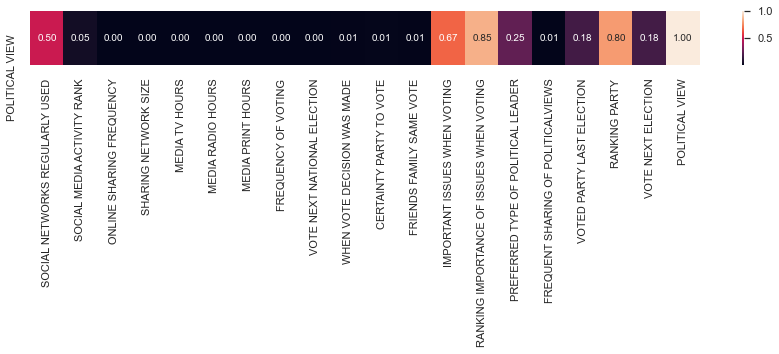

In [580]:
plt.figure(figsize=(15,1))
sns.heatmap(utheil,annot=True,fmt='.2f')
plt.show()

Osservando il grafico osserviamo come alcune variabili riescano a spiegare molto della preferenza politica di un campione, quindi preferiamo mantenere questi campi ed eliminare la popolazione che non ha risposto a queste domande dal dataset.

In [581]:
data.drop(data.loc[data[nullData.index[0]].isnull()].index, inplace=True)

In [582]:
data.shape

(7951, 70)

Ricalcoliamo ora i campi con dati mancanti e la percentuale di dati nulli rispetto al totale

In [583]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

SOCIAL MEDIA ACTIVITY RANK                   3.295183
ONLINE SHARING FREQUENCY                     3.295183
RANKING IMPORTANCE OF ISSUES WHEN VOTING     8.539806
SHARING NETWORK SIZE                        10.099359
CERTAINTY PARTY TO VOTE                     15.054710
FRIENDS FAMILY SAME VOTE                    15.054710
WHEN VOTE DECISION WAS MADE                 34.423343
HOMETOWN CHANGE PAST5YEARS                  40.699283
ORGANIZATION ACTIVITIES TIMEPERWEEK         55.238335
dtype: float64

Osserviamo come la percentuale di dati nulli per le colonne _ORGANIZATION ACTIVITIES TIMEPERWEEK_ e _HOMETOWN CHANGE PAST5YEARS_ siano salite, questo vuol dire che l'eliminazione dei campioni precedenti non ha eliminiato i valori nulli in questi campi, come evidenziato anche in precedenza (queste due colonne non rientravano nelle domande a cui i campioni precedenti non avevano risposto).

Analizziamo la colonna _SOCIAL MEDIA ACTIVITY RANK_:

In [584]:
data['SOCIAL NETWORKS REGULARLY USED'][data['SOCIAL MEDIA ACTIVITY RANK'].isnull()].unique()

array(["I don't use any social media platform"], dtype=object)

Prevedibilmente i rimanenti dati nulli di questo campo sono relativi a persone che non usano Social Media, quindi sostituiamo i dati mancanti con un'informazione che indichi il non uso dei Social Media:

In [585]:
data['SOCIAL MEDIA ACTIVITY RANK'].fillna("I don't use any social media platform", inplace=True)

In [586]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

ONLINE SHARING FREQUENCY                     3.295183
RANKING IMPORTANCE OF ISSUES WHEN VOTING     8.539806
SHARING NETWORK SIZE                        10.099359
CERTAINTY PARTY TO VOTE                     15.054710
FRIENDS FAMILY SAME VOTE                    15.054710
WHEN VOTE DECISION WAS MADE                 34.423343
HOMETOWN CHANGE PAST5YEARS                  40.699283
ORGANIZATION ACTIVITIES TIMEPERWEEK         55.238335
dtype: float64

Osserviamo ora la colonna _ONLINE SHARING FREQUENCY_:

In [587]:
data['ONLINE SHARING FREQUENCY'].unique()

array([nan, 'At least once a week', 'Less often', 'At least once a month',
       'A few times a month', 'Most days', 'Never'], dtype=object)

In [588]:
data['SOCIAL NETWORKS REGULARLY USED'][data['ONLINE SHARING FREQUENCY'].isnull()].unique()

array(["I don't use any social media platform"], dtype=object)

Anche qui i valori nulli sono dati da chi non usa Social Networks, quindi riempiamo i valori nulli allo stesso modo della colonna precedente:

In [589]:
data['ONLINE SHARING FREQUENCY'].fillna("I don't use any social media platform", inplace=True)

In [590]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

RANKING IMPORTANCE OF ISSUES WHEN VOTING     8.539806
SHARING NETWORK SIZE                        10.099359
CERTAINTY PARTY TO VOTE                     15.054710
FRIENDS FAMILY SAME VOTE                    15.054710
WHEN VOTE DECISION WAS MADE                 34.423343
HOMETOWN CHANGE PAST5YEARS                  40.699283
ORGANIZATION ACTIVITIES TIMEPERWEEK         55.238335
dtype: float64

Osserviamo _RANKING IMPORTANCE OF ISSUES WHEN VOTING_:

In [591]:
data['RANKING IMPORTANCE OF ISSUES WHEN VOTING'].unique()

array(['More wealth redistribution | Higher wages | Lower taxes | Equal rights for minority groups | Higher pensions',
       'More environmental protection | Better schools | Equal rights for minority groups | More jobs',
       'More environmental protection | Better schools | Better healthcare | Lower costs of living (e.g. rent, water, energy) | Higher pensions',
       ...,
       'More environmental protection | More jobs | Lower taxes | Better healthcare | Better schools',
       'Higher pensions | More jobs | More environmental protection | Higher wages | Better healthcare',
       'More wealth redistribution | Higher wages | Equal rights for minority groups | Lower costs of living (e.g. rent, water, energy) | Better enforcement of law and order'],
      dtype=object)

Per decidere se eliminare la colonna o i campioni nulli calcoliamo la U di Theil su questo campo per vedere se riesce a spiegare qualcosa delle preferenze politiche:

In [592]:
theil_u(data['POLITICAL VIEW'].tolist(), data['RANKING IMPORTANCE OF ISSUES WHEN VOTING'].dropna().tolist())

0.8123953815981569

Il valore è molto alto quindi scegliamo di mantenere il campo ed eliminare i dati nulli:

In [593]:
data.drop(data[data['RANKING IMPORTANCE OF ISSUES WHEN VOTING'].isnull()].index, inplace=True)

In [594]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

SHARING NETWORK SIZE                    9.378438
CERTAINTY PARTY TO VOTE                12.142464
FRIENDS FAMILY SAME VOTE               12.142464
WHEN VOTE DECISION WAS MADE            31.311881
HOMETOWN CHANGE PAST5YEARS             40.869087
ORGANIZATION ACTIVITIES TIMEPERWEEK    54.262926
dtype: float64

Osserviamo ora la colonna _SHARING NETWORK SIZE_:

In [595]:
data['SHARING NETWORK SIZE'].unique()

array([nan, '101 - 500', 'Under 100', '2 001 - 5 000', '501 - 1 000',
       '1 000 - 2 000', 'More than 10 000', '5 001 - 10 000'],
      dtype=object)

In [596]:
data['SOCIAL NETWORKS REGULARLY USED'][data['SHARING NETWORK SIZE'].isnull()].value_counts().sort_values()

WhatsApp | Instagram | Google+ | Facebook | Snapchat | YouTube        1
Snapchat | WhatsApp | Pinterest | YouTube | Instagram | Facebook      1
Viber                                                                 1
YouTube | Facebook | Viber                                            1
WhatsApp | YouTube | Instagram | Facebook | Snapchat                  1
                                                                   ... 
Facebook                                                             23
WhatsApp | YouTube                                                   23
WhatsApp                                                             50
YouTube                                                              60
I don't use any social media platform                               209
Name: SOCIAL NETWORKS REGULARLY USED, Length: 181, dtype: int64

Questa colonna indica il range di personeScegliamo di rimuovere questa colonna dal dataset in quanto il suo significato risulta ambiguo e non direttamente interpretabile dal dataset:

In [597]:
data.drop('SHARING NETWORK SIZE', axis=1, inplace=True)

In [598]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

CERTAINTY PARTY TO VOTE                12.142464
FRIENDS FAMILY SAME VOTE               12.142464
WHEN VOTE DECISION WAS MADE            31.311881
HOMETOWN CHANGE PAST5YEARS             40.869087
ORGANIZATION ACTIVITIES TIMEPERWEEK    54.262926
dtype: float64

Osseviamo che _CERTAINTY PARTY TO VOTE_ e _FRIENDS FAMILY SAME VOTE_ hanno la stessa percentuale di valori nulli, osserviamole insieme: 

In [599]:
data['CERTAINTY PARTY TO VOTE'].unique()

array(['Very certain', nan, 'Not very certain', 'Somewhat certain',
       'Not at all certain'], dtype=object)

In [600]:
data['FRIENDS FAMILY SAME VOTE'].unique()

array(['All', nan, 'About half', 'Most', 'Only few', 'Less than half'],
      dtype=object)

In [601]:
data['FRIENDS FAMILY SAME VOTE'][data['CERTAINTY PARTY TO VOTE'].isnull()].isnull().all()

True

In [602]:
data['CERTAINTY PARTY TO VOTE'][data['FRIENDS FAMILY SAME VOTE'].isnull()].isnull().all()

True

Quindi chi non ha risposto ad un campo non ha risposto neanche all'altro. Osserviamo una singola riga e vediamo di trarre qualche informazione:

In [603]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data[data['CERTAINTY PARTY TO VOTE'].isnull()].iloc[0, :])

COUNTRY CODE                                                                               DE
AGE                                                                                        16
GENDER                                                                                 female
EDUCATION LEVEL                             I have some high school or secondary school ed...
DEGREE OF URBANISATION                                                                  rural
RESIDENCY                                                                   Yes, as a citizen
HOUSEHOLD SIZE                                                                              4
IMMIGRATION                                 One or both of my parents moved here before I ...
SETTLEMENT SIZE                                                                   Countryside
HOMETOWN                                                                                   No
ETHNIC BACKGROUND                                Hispanic or

In [604]:
data['FRIENDS FAMILY SAME VOTE'][data['CERTAINTY PARTY TO VOTE'] == 'Not at all certain'].unique()

array(['Only few', 'Less than half', 'Most', 'About half', 'All'],
      dtype=object)

Da un'osservazione di un campione sembrerebbe che chi non ha certezza sul partito da votare non abbia risposto a questa domanda e non può neanche dire se amici e famiglia abbiano lo stesso voto. Quindi scegliamo di colmare i dati nulli con un'informazione che indichi la loro non preferenza: 

In [605]:
data['CERTAINTY PARTY TO VOTE'].fillna('Not certain', inplace=True)

In [606]:
data['FRIENDS FAMILY SAME VOTE'].fillna('Not certain what to vote', inplace=True)

In [607]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

WHEN VOTE DECISION WAS MADE            31.311881
HOMETOWN CHANGE PAST5YEARS             40.869087
ORGANIZATION ACTIVITIES TIMEPERWEEK    54.262926
dtype: float64

Osserviamo la colonna _WHEN VOTE DECISION WAS MADE_:

In [608]:
data['WHEN VOTE DECISION WAS MADE'].unique()

array(["I always voted for the same party / party's candidate",
       'At least a week before election day', nan, 'During election day',
       'A few months before election day',
       'At least a month before election day'], dtype=object)

In [609]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data[data['WHEN VOTE DECISION WAS MADE'].isnull()].iloc[0, :])

COUNTRY CODE                                                                               DE
AGE                                                                                        45
GENDER                                                                                   male
EDUCATION LEVEL                             I have completed a university or equivalent de...
DEGREE OF URBANISATION                                                                  rural
RESIDENCY                                                                   Yes, as a citizen
HOUSEHOLD SIZE                                                                              3
IMMIGRATION                                                                 None of the above
SETTLEMENT SIZE                                             Town with fewer than 1 000 people
HOMETOWN                                                                                   No
ETHNIC BACKGROUND                                           

In [610]:
data.loc[data['WHEN VOTE DECISION WAS MADE'].isnull() == True ,'POLITICAL VIEW'].value_counts()

Center left      734
Center right     709
Left             373
Right            275
Extreme right    105
Extreme left      81
Name: POLITICAL VIEW, dtype: int64

Da un'osservazione del dataset non si è in grado di trarre una spiegazione per la mancanza di dati in questa colonna. Per decidere se eliminarla o meno osserviamo la correlazione tra questa variabile e la nostra variabile di interesse per i dati non nulli:

In [611]:
theil_u(data['POLITICAL VIEW'].tolist(), data['WHEN VOTE DECISION WAS MADE'].dropna().tolist())

0.014799173272800219

L'indice U è quasi pari allo zero, quindi scegliamo di rimuovere questa colonna dal dataset.

In [612]:
data.drop('WHEN VOTE DECISION WAS MADE', axis=1, inplace=True)

In [613]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

HOMETOWN CHANGE PAST5YEARS             40.869087
ORGANIZATION ACTIVITIES TIMEPERWEEK    54.262926
dtype: float64

Restano due colonne che hanno quasi la metà di dati mancanti: _ORGANIZATION ACTIVITIES TIMEPERWEEK_ è già stata osservata in precedenza, osserviamo se ci sia qualche relazione tra questa colonna e la nostra variabile di interesse, in caso positivo manterremo la colonna altrimenti la elimineremo:

In [614]:
data['POLITICAL VIEW'][data['ORGANIZATION ACTIVITIES TIMEPERWEEK'].isnull() == True].value_counts()

Center left      1228
Center right     1150
Left              712
Right             528
Extreme right     190
Extreme left      138
Name: POLITICAL VIEW, dtype: int64

In [615]:
theil_u(data['POLITICAL VIEW'].tolist(), data['ORGANIZATION ACTIVITIES TIMEPERWEEK'].dropna().tolist())

0.05497750375604001

Anche in questo caso l'indice U è quasi pari a zero, quindi scegliamo di rimuovere interamente la feature:

In [616]:
data.drop('ORGANIZATION ACTIVITIES TIMEPERWEEK', axis=1, inplace=True)

Osserviamo infine _HOMETOWN CHANGE PAST5YEARS_ ed una sua eventuale correlazione con la variabile di interesse:

In [617]:
data['HOMETOWN CHANGE PAST5YEARS'].unique()

array([nan, "Don't know enough to say", 'The same', 'Somewhat better',
       'Somewhat worse', 'Much better', 'Much worse'], dtype=object)

In [618]:
data['POLITICAL VIEW'][data['HOMETOWN CHANGE PAST5YEARS'].isnull()].value_counts()

Center left      922
Center right     881
Left             507
Right            406
Extreme right    149
Extreme left     107
Name: POLITICAL VIEW, dtype: int64

In [619]:
theil_u(data['POLITICAL VIEW'].tolist(), data['HOMETOWN CHANGE PAST5YEARS'].dropna().tolist())

0.011173349585499322

Anche in questo caso scegliamo di rimuovere questa colonna, dal momento che non risulta molto significativa.

In [620]:
data.drop('HOMETOWN CHANGE PAST5YEARS', axis=1, inplace=True)

In [621]:
null_columns = data.isnull().any()[data.isnull().any() == True]
nullData = (data[null_columns.index].isnull().sum()/len(data.index))*100
nullData.sort_values(ascending=True, inplace=True)
nullData

Series([], dtype: float64)

In [622]:
data.shape

(7272, 66)

Come ultima operazione aggiungiamo una colonna che indichi il nome per esteso dei paesi di riferimento:

In [623]:
data['COUNTRY CODE'].unique()

array(['DE', 'ES', 'FR', 'GB', 'IT', 'PL'], dtype=object)

In [624]:
data.head()

,COUNTRY CODE,AGE,GENDER,EDUCATION LEVEL,DEGREE OF URBANISATION,RESIDENCY,HOUSEHOLD SIZE,IMMIGRATION,SETTLEMENT SIZE,HOMETOWN,...,CONSPIRACY,GOVERNMENT CONTROLLED BY ELITE,TRUST IN OWN JUDGMENT,PERCEIVED EFFECT OF DIVERSITY,GENDER DISCRIMINATION IMPORTANCE,FAMILY FRIENDS HIGHEREDUCATION,WORLDVIEW,VOTED PARTY LAST ELECTION,RANKING PARTY,VOTE NEXT ELECTION
UUID,,,,,,,,,,,,,,,,,,,,,
c8051460-a0fa-0134-e47f-0aaafcbd6b1f,DE,36,male,I completed high school or obtained an equival...,city,"Yes, as a citizen",1,One or both of my parents moved here before I ...,Town with 1 000 - 50 000 people,No,...,Strongly agree,Neither agree nor disagree,Strongly agree,Somewhat negatively,"Yes, somewhat",About half,"It's a big, beautiful world, mostly full of go...","Yes, I voted for Die Linke",Die Linke | SPD – Sozialdemokratische Partei D...,Die Linke
6bbef710-a060-0134-8ddc-0aaafcbd6b1f,DE,16,female,I have some high school or secondary school ed...,rural,"Yes, as a citizen",4,One or both of my parents moved here before I ...,Countryside,No,...,Neither agree nor disagree,Somewhat agree,Strongly agree,Neither positively nor negatively,"Yes, very",All of them,"It's a big, beautiful world, mostly full of go...","Yes, I voted for CDU/CSU – Christlich Demokrat...",CDU/CSU – Christlich Demokratische Union/Chris...,I would not vote
1d72cbd0-9f53-0134-0d5d-0aaafcbd6b1f,DE,45,male,I have completed a university or equivalent de...,rural,"Yes, as a citizen",3,None of the above,Town with fewer than 1 000 people,No,...,Strongly disagree,Somewhat agree,Neither agree nor disagree,Somewhat positively,"Yes, somewhat",Most of them,"It's a big, beautiful world, mostly full of go...",I wanted to vote but I wasn't able to,CDU/CSU – Christlich Demokratische Union/Chris...,SPD – Sozialdemokratische Partei Deutschlands
f90f8c20-9e95-0134-cceb-0a62e1402143,DE,30,female,Other/I'd rather not answer this question,city,"Yes, as a citizen",5 or more,My family has been here for a longer time,City with 1 million - 5 million people,Yes,...,Somewhat agree,Neither agree nor disagree,Somewhat agree,Neither positively nor negatively,"Yes, very",Most of them,"Our lives are threatened by terrorists, crimin...","Yes, I voted for CDU/CSU – Christlich Demokrat...",CDU/CSU – Christlich Demokratische Union/Chris...,CDU/CSU – Christlich Demokratische Union/Chris...
4106d1c0-9d60-0134-b693-0a62e1402143,DE,59,female,I completed high school or obtained an equival...,city,"Yes, as a citizen",3,My grandparents moved here,City with 50 000 - 250 000 people,Yes,...,Somewhat agree,Strongly agree,Neither agree nor disagree,Neither positively nor negatively,"Yes, somewhat",About half,"Our lives are threatened by terrorists, crimin...","Yes, I voted for SPD – Sozialdemokratische Par...",SPD – Sozialdemokratische Partei Deutschlands ...,SPD – Sozialdemokratische Partei Deutschlands


In [625]:
data.shape

(7272, 66)

Quindi al termine di questa fase abbiamo un dataset composto da 7272 campioni e 67 colonne che rappresentano una sotto porzione significativa delle domande sottoposte.

Come ultima operazione modifichiamo il tipo dei dati da object a category, così da avere in seguito accesso ad alcuni metodi di supporto per le analisi:

In [626]:
data[data.select_dtypes(['object']).columns] = data.select_dtypes(include=['object']).apply(lambda x: x.astype('category'))

In [627]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7272 entries, c8051460-a0fa-0134-e47f-0aaafcbd6b1f to b50a1130-9d42-0134-98d3-0a62e1402143
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   COUNTRY CODE                              7272 non-null   category
 1   AGE                                       7272 non-null   int64   
 2   GENDER                                    7272 non-null   category
 3   EDUCATION LEVEL                           7272 non-null   category
 4   DEGREE OF URBANISATION                    7272 non-null   category
 5   RESIDENCY                                 7272 non-null   category
 6   HOUSEHOLD SIZE                            7272 non-null   category
 7   IMMIGRATION                               7272 non-null   category
 8   SETTLEMENT SIZE                           7272 non-null   category
 9   HOMETOWN                          

Completata questa fase è possibile ora svolgere un po' di statistica esplorativa.

## Statistica esplorativa generale

In [628]:
colorsMap = {
    'Extreme left': '#ff0000',
    'Left': '#FFBF00',
    'Center left': '#CE45FF',
    'Center right': '#0040FF',
    'Right': '#156603',
    'Extreme right': '#696969'
}
sns.set_theme(style="whitegrid")

In [629]:
countryNames = pd.Series({
    'DE': 'Germany',
    'ES': 'Spain',
    'FR': 'France',
    'GB': 'England',
    'IT': 'Italy',
    'PL': 'Poland'
}, name='COUNTRY', dtype='category')
dataCountry = data.join(countryNames, on= data['COUNTRY CODE'])

Analizziamo ora un po' di caratteristiche generali del dataset prima di concentrarci su aspetti più specifici.

Iniziamo con il calcolare la percentuale delle preferenze politiche dell'intero dataset e la percentuale di partecipanti al sondaggio per ogni nazione, così da avere un'idea complessiva dei partecipanti al sondaggio dopo le operazioni di _data cleaning_:

In [630]:
politicalPref = dataCountry['POLITICAL VIEW'].value_counts().reset_index()
countryCounts = dataCountry['COUNTRY'].value_counts().reset_index()

In [631]:
politicalPref.columns = ['Political view', 'Percentage']
politicalPref['Percentage'] = (politicalPref['Percentage']/len(data.index))*100
politicalPref

,Political view,Percentage
0,Center left,31.023102
1,Center right,29.359186
2,Left,17.505501
3,Right,13.875138
4,Extreme right,4.702970
5,Extreme left,3.534103


In [632]:
countryCounts.columns = ['Country', 'Percentage']
countryCounts['Percentage'] = (countryCounts['Percentage']/len(data.index))*100
countryCounts

,Country,Percentage
0,Germany,23.528603
1,France,18.358086
2,England,17.202970
3,Italy,15.497800
4,Spain,12.885039
5,Poland,12.527503


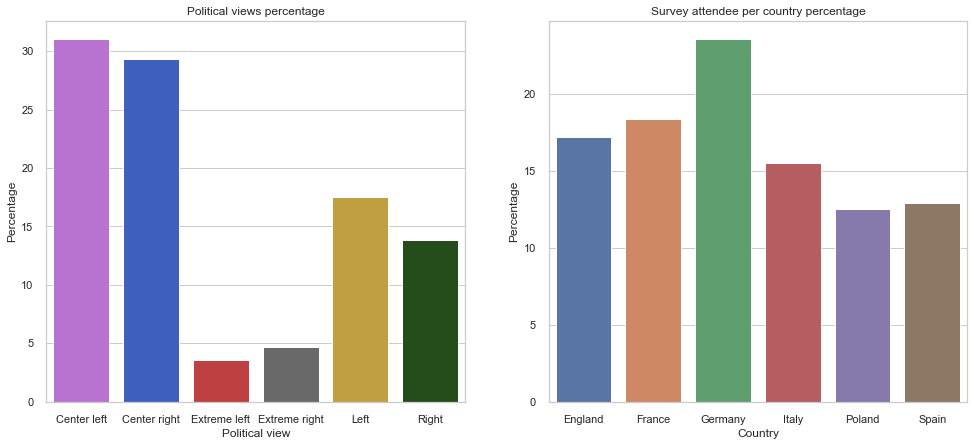

In [633]:
fig, ax = plt.subplots(1, 2, figsize=(16.5, 7))
sns.barplot(data=politicalPref, x='Political view', y='Percentage', ax=ax[0], palette=colorsMap, saturation=0.5)
ax[0].set(title='Political views percentage')
sns.barplot(data=countryCounts, x='Country', y='Percentage', ax=ax[1])
ax[1].set(title='Survey attendee per country percentage')
plt.show()

Quindi il sondaggio è stato sottoposto maggiormente a persone tedesche che coprono più del 20% del campione totale. L'Italia occupa circa il 15% del campione.

Circa il 60% della popolazione totale ha preferenze di Centro destra o Centro sinistra. Com'era prevedibile le preferenze minori riguardano partiti di Estrema destra (circa il 5%) ed Estrema sinistra (meno del 5%).

Calcoliamo ora le preferenze politiche percentuali per ogni paese:

In [634]:
polViewByCountry = dataCountry[['POLITICAL VIEW', 'COUNTRY CODE', 'COUNTRY']]

In [635]:
polViewByCountry = polViewByCountry.join(
    pd.get_dummies(polViewByCountry['POLITICAL VIEW']))\
 .drop('POLITICAL VIEW', axis=1)

In [636]:
mean = polViewByCountry.groupby('COUNTRY').mean()*100

In [637]:
mean

,Center left,Center right,Extreme left,Extreme right,Left,Right
COUNTRY,,,,,,
England,32.454037,36.610711,4.156675,2.877698,13.509193,10.391687
France,19.625468,19.550562,6.217228,12.359551,21.722846,20.524345
Germany,45.821157,33.664524,1.636470,1.461134,14.026885,3.389831
Italy,27.861579,29.636202,3.992902,5.235138,15.173026,18.101154
Poland,22.283205,29.418222,3.293085,3.951701,15.587267,25.466520
Spain,30.629669,25.400213,2.027748,2.241195,27.854856,11.846318


In [638]:
mean = mean.melt(var_name='POLITICAL VIEW', value_name='MEAN', ignore_index=False).reset_index()

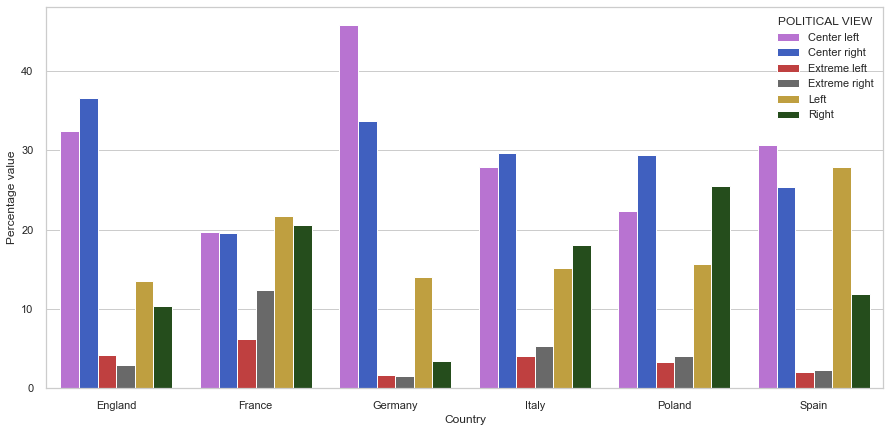

In [639]:
fig, ax = plt.subplots(figsize=(15,7))
ax = sns.barplot(data=mean, x='COUNTRY', y='MEAN', hue='POLITICAL VIEW', palette=colorsMap, saturation=0.5)
ax.set(xlabel="Country", ylabel = "Percentage value")
plt.show()

Da questo grafico possiamo notare come per ogni paese le preferenze maggiori siano sui partiti di Centro destra e Centro sinistra. E' interessante anche notare come in Francia ci sia una maggiore distribuzione delle preferenze politiche, in Spagna ci sia un'elevata preferenza anche nei partiti di sinistra ed in Polonia la preferenza politica di Destra superi addirittura la preferenza politica di Centro sinistra. 

L'Italia ha una leggera preferenza per i partiti di Centro destra, mentre notiamo come le preferenze di Destra coprano circa il 20% del campione italiano. 

In generale possiamo dire che l'appartenenza ad un paese piuttosto che ad un altro influisce sulle preferenze politiche.

Osserviamo ora la distribuzione d'età all'interno del dataset:

In [640]:
data['AGE'].describe()

count    7272.000000
mean       36.208746
std        12.480341
min        14.000000
25%        26.000000
50%        36.000000
75%        46.000000
max        65.000000
Name: AGE, dtype: float64

Età più frequente: 26


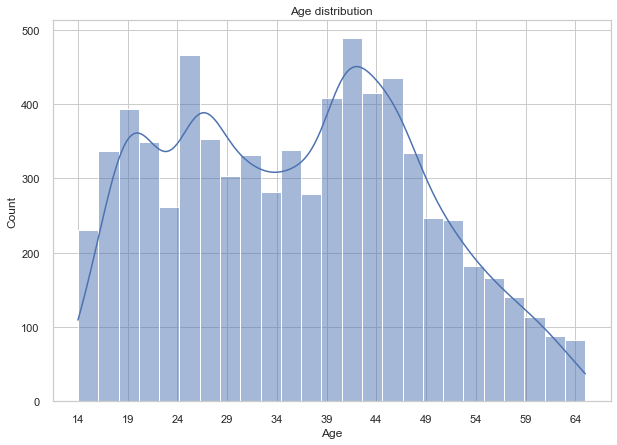

In [641]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=data, x='AGE', kde=True, ax=ax)
ax.set_title('Age distribution')
ax.set(xlabel='Age')
ax.set_xticks(
    np.arange(min(data['AGE']), max(data['AGE']), 5)
)
mode = data['AGE'].mode().iloc[0]
print('Età più frequente: '+str(mode))

Notiamo come il campione abbia una distribuzione di età abbastanza uniforme tra i 20 ed i 40 anni con un picco tra i 40 ed i 45 anni. L'età minima è 14 anni mentre l'età maggiore è 65 anni. L'età più frequente nel campione è 26 anni.

Analizziamo ora la distribuzione d'età per paese di appartenenza:

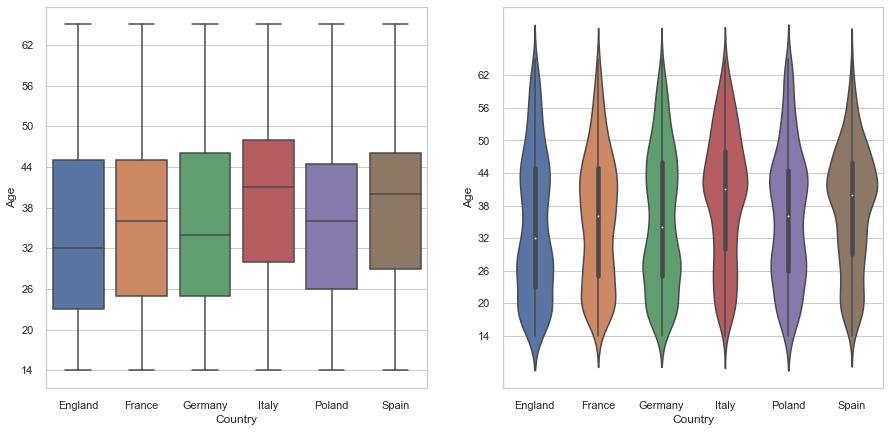

In [642]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data=dataCountry, x='COUNTRY', y='AGE', ax=ax[0])
sns.violinplot(data=dataCountry, x='COUNTRY', y='AGE', ax=ax[1])
ax[0].set(xlabel= "Country", ylabel= "Age")
ax[1].set(xlabel= "Country", ylabel= "Age")
ax[0].set_yticks(
    np.arange(min(data['AGE']), max(data['AGE']), 6)
)
ax[1].set_yticks(
    np.arange(min(data['AGE']), max(data['AGE']), 6)
)
plt.show()

Osserviamo come tutti paesi abbiano lo stesso range di età che come visto in precedenza va dai 14 ai 65 anni. Il campione inglese è quello con le età più equalmente distribuite, con il campione che si distribuisce maggiormente tra i 23 ed i 45 anni, anche se notiamo dal plot di destra come vi sia una maggiore concentrazione tra i 19 ed i 30 anni. I campioni più "anziani" risultano essere quelli italiani e spagnoli, con un range di età che varia maggiormente tra i 30 ed i 50 anni con una maggiore concentrazione tra i 40 ed i 45 anni.

Infine calcoliamo le distribuzione d'età per preferenza politica:

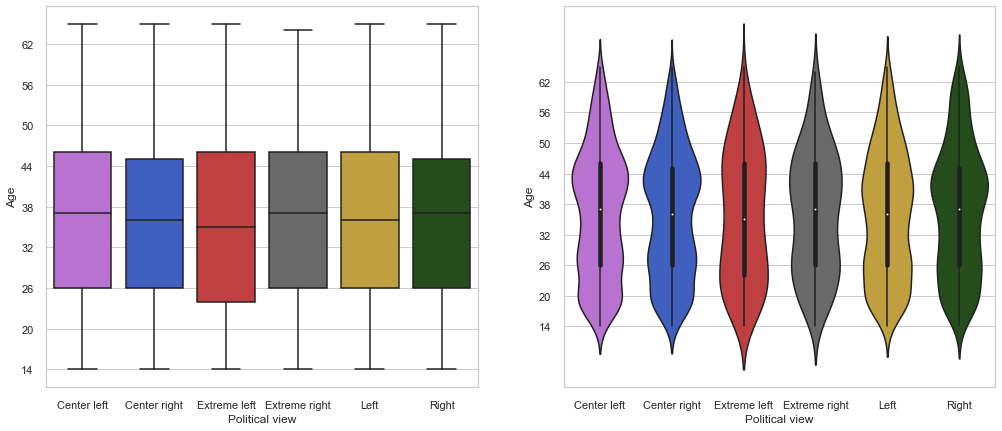

In [643]:
fig, ax = plt.subplots(1, 2, figsize=(17,7))
sns.boxplot(data=data, x='POLITICAL VIEW', y='AGE', ax=ax[0], palette=colorsMap, saturation=0.5)
sns.violinplot(data=data, x='POLITICAL VIEW', y='AGE', ax=ax[1], palette=colorsMap,  saturation=0.5)
ax[0].set(xlabel= "Political view", ylabel='Age')
ax[1].set(xlabel= "Political view", ylabel='Age')
ax[0].set_yticks(
    np.arange(min(data['AGE']), max(data['AGE']), 6)
)
ax[1].set_yticks(
    np.arange(min(data['AGE']), max(data['AGE']), 6)
)
plt.show()

In questo caso le distribuzioni sono piuttosto equilibrate e non c'è una particolare differenza di età relativamente alle preferenze politiche. Da notare come il valore minimo sia uguale per tutte le preferenze politiche, mentre il valore massimo è leggermente minore per le preferenze di estrema destra. Anche la densità dei campioni risulta piuttosto equilibrata. 

Da questa osservazione sembrerebbe che l'età non è un forte discriminatore dell'orientamento politico.

### Analisi correlazione

Prima di andare avanti nell'esplorazione di altre variabili calcoliamo la correlazione tra le varie feature del dataset e la nostra variabile dipendente _POLITICAL VIEW_ così da selezionare ed analizzare solo quelle che effettivamente riescono a spiegare una parte significativa di questo fenomeno.

Per le variabili categoriche utilizziamo l'indice _U di Theil_ già descritto in precedenza:

In [644]:
def showCorr():
    catCol = data.columns
    theilu = pd.DataFrame(index=['class'], columns=catCol)
    for c in catCol:
        u = theil_u(data['POLITICAL VIEW'].tolist(), data[c].tolist())
        theilu.loc[:, c] = u
    theilu.fillna(value=np.nan,inplace=True)
    return theilu

In [645]:
theilu = showCorr().melt().sort_values(by='value', ascending=False)
theilu.iloc[1:10]

,variable,value
41,RANKING IMPORTANCE OF ISSUES WHEN VOTING,0.812092
64,RANKING PARTY,0.753259
40,IMPORTANT ISSUES WHEN VOTING,0.609045
25,SOCIAL NETWORKS REGULARLY USED,0.429138
42,PREFERRED TYPE OF POLITICAL LEADER,0.168845
65,VOTE NEXT ELECTION,0.142132
63,VOTED PARTY LAST ELECTION,0.119829
0,COUNTRY CODE,0.041992
26,SOCIAL MEDIA ACTIVITY RANK,0.031093


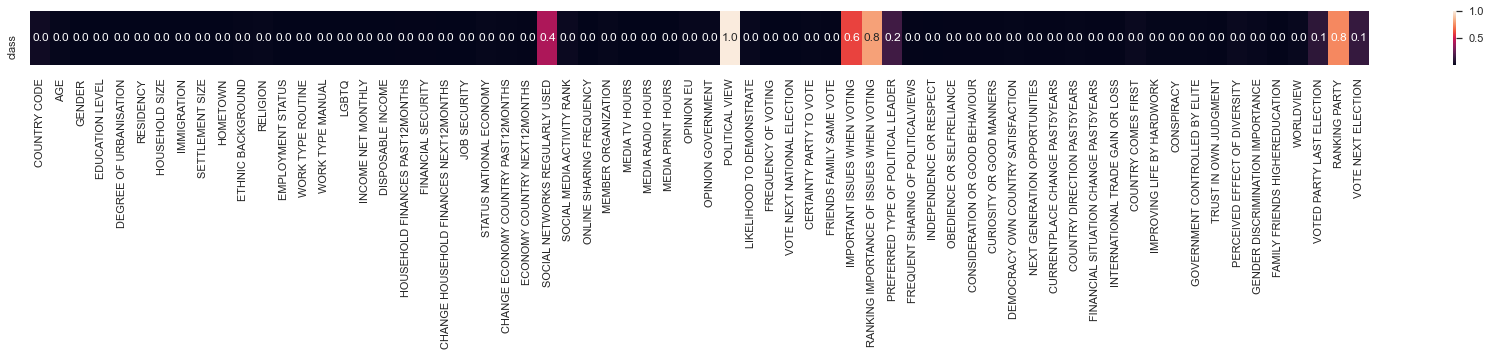

In [646]:
plt.figure(figsize=(30,1))
sns.heatmap(showCorr(), annot=True, fmt='.1f')
plt.show()

Notiamo come la variabile _RANKING IMPORTANCE OF ISSUES WHEN VOTING_ riesca a spiegare l'80% della variabilità di _POLITICAL VIEW_, come anche _RANKING PARTY_ ne spieghi quasi la stessa percentuale. Esploriamo meglio il contenuto di queste variabili che riescono a spiegare un'alta percentuale della nostra variabile dipendente:

In [647]:
data['RANKING IMPORTANCE OF ISSUES WHEN VOTING'].unique()

['More wealth redistribution | Higher wages | L..., 'More environmental protection | Better school..., 'More environmental protection | Better school..., 'More environmental protection | More jobs | B..., 'Better healthcare | Better enforcement of law..., ..., 'Better schools | Better healthcare | More job..., 'Better healthcare | More jobs | Higher wages ..., 'More environmental protection | More jobs | L..., 'Higher pensions | More jobs | More environmen..., 'More wealth redistribution | Higher wages | E...]
Length: 5674
Categories (5674, object): ['More wealth redistribution | Higher wages | L..., 'More environmental protection | Better school..., 'More environmental protection | Better school..., 'More environmental protection | More jobs | B..., ..., 'Better healthcare | More jobs | Higher wages ..., 'More environmental protection | More jobs | L..., 'Higher pensions | More jobs | More environmen..., 'More wealth redistribution | Higher wages | E...]

In [648]:
len(data['RANKING IMPORTANCE OF ISSUES WHEN VOTING'].unique())

5674

C:\Users\giord\miniconda3\envs\mwt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


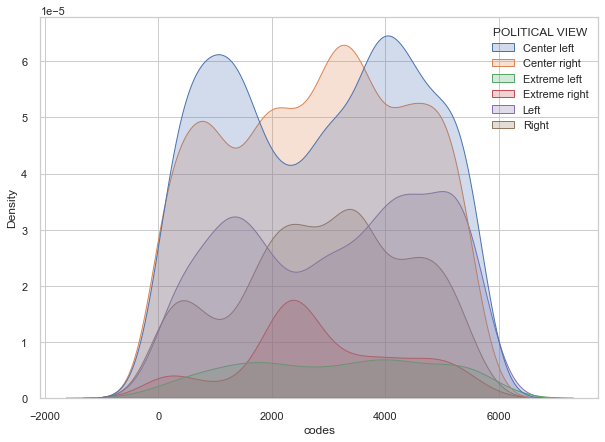

In [649]:
tmp = data[['POLITICAL VIEW', 'RANKING IMPORTANCE OF ISSUES WHEN VOTING']]
tmp['codes'] = tmp['RANKING IMPORTANCE OF ISSUES WHEN VOTING'].cat.codes
plt.figure(figsize=(10,7))
sns.kdeplot(x='codes', data=tmp, hue='POLITICAL VIEW', fill=True)
plt.show()

In [650]:
len(data['RANKING PARTY'].unique())

4301

In realtà l'alto valore dell'indice U per questi campi è spiegato dall'alta variabilità degli stessi, che sono essenzialmente un ranking delle preferenze dei vari campioni. Dal momento che molte modalità di questi campi si presentano solo una volta all'interno del dataset questo porta ad un aumento della probabilità di incontrare data una modalità di $Y$ sempre la stessa modalità di $X$ e, di conseguenza, ad un aumento dell'indice U per questo campo.

Lo stesso fenomeno si verifica anche per le altre variabili con un alto valore dell'indice U:

In [651]:
len(data['SOCIAL NETWORKS REGULARLY USED'].unique())

2777

In [652]:
len(data['IMPORTANT ISSUES WHEN VOTING'].unique())

3902

In [653]:
len(data['PREFERRED TYPE OF POLITICAL LEADER'].unique())

717

Per risolvere questo problema esplodiamo questi campi creando una colonna per ogni valore univoco ed associando 1 alle persone che hanno indicato quella specifica modalità, prima di questa operazione però eliminiamo dal dataset le colonne _RANKING PARTY_ e _'RANKING IMPORTANCE OF ISSUES WHEN VOTING_ in quanto troppo dispersive e non in grado di essere rappresentate in modo diverso:

In [654]:
data.drop(['RANKING IMPORTANCE OF ISSUES WHEN VOTING', 'RANKING PARTY'], axis=1, inplace=True)

In [655]:
def explodeColumns(data, columns):
    for col in columns:
        tmp = (
            pd.get_dummies(
                data[col].str.split('|').explode().apply(lambda x: '['+col+'] '+x.strip())
            ).reset_index().groupby('UUID').sum())
        data = data.join(tmp)
        data.drop(col, axis=1, inplace=True)
    return data

In [656]:
data = explodeColumns(data, theilu['variable'].iloc[3:6].tolist())
data = explodeColumns(data, ['SOCIAL MEDIA ACTIVITY RANK'])

In [657]:
data.head()

,COUNTRY CODE,AGE,GENDER,EDUCATION LEVEL,DEGREE OF URBANISATION,RESIDENCY,HOUSEHOLD SIZE,IMMIGRATION,SETTLEMENT SIZE,HOMETOWN,...,[PREFERRED TYPE OF POLITICAL LEADER] … focuses on practical solutions,[PREFERRED TYPE OF POLITICAL LEADER] … has the right experience,[PREFERRED TYPE OF POLITICAL LEADER] … is close to the people,[PREFERRED TYPE OF POLITICAL LEADER] … speaks his / her mind,[SOCIAL MEDIA ACTIVITY RANK] Commenting on other people's posts,[SOCIAL MEDIA ACTIVITY RANK] Connecting with new people,[SOCIAL MEDIA ACTIVITY RANK] Creating posts to express my opinion,[SOCIAL MEDIA ACTIVITY RANK] I don't use any social media platform,[SOCIAL MEDIA ACTIVITY RANK] Reading what other people have to say,[SOCIAL MEDIA ACTIVITY RANK] Sharing interesting content
UUID,,,,,,,,,,,,,,,,,,,,,
c8051460-a0fa-0134-e47f-0aaafcbd6b1f,DE,36,male,I completed high school or obtained an equival...,city,"Yes, as a citizen",1,One or both of my parents moved here before I ...,Town with 1 000 - 50 000 people,No,...,1,1,1,1,0,0,0,1,0,0
6bbef710-a060-0134-8ddc-0aaafcbd6b1f,DE,16,female,I have some high school or secondary school ed...,rural,"Yes, as a citizen",4,One or both of my parents moved here before I ...,Countryside,No,...,1,1,1,1,1,1,1,0,1,1
1d72cbd0-9f53-0134-0d5d-0aaafcbd6b1f,DE,45,male,I have completed a university or equivalent de...,rural,"Yes, as a citizen",3,None of the above,Town with fewer than 1 000 people,No,...,1,1,1,1,1,1,1,0,1,1
f90f8c20-9e95-0134-cceb-0a62e1402143,DE,30,female,Other/I'd rather not answer this question,city,"Yes, as a citizen",5 or more,My family has been here for a longer time,City with 1 million - 5 million people,Yes,...,1,1,1,1,1,1,1,0,1,1
4106d1c0-9d60-0134-b693-0a62e1402143,DE,59,female,I completed high school or obtained an equival...,city,"Yes, as a citizen",3,My grandparents moved here,City with 50 000 - 250 000 people,Yes,...,1,1,1,1,1,1,1,0,1,1


In [658]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7272 entries, c8051460-a0fa-0134-e47f-0aaafcbd6b1f to b50a1130-9d42-0134-98d3-0a62e1402143
Columns: 103 entries, COUNTRY CODE to [SOCIAL MEDIA ACTIVITY RANK] Sharing interesting content
dtypes: category(59), int64(1), uint8(43)
memory usage: 1.1+ MB


Quindi dopo questa operazione abbiamo aumentato il numero di variabili, ma diminuito la variabilità di alcune di esse che altrimenti avrebbe influito negativamente sulle nostre analisi. Andiamo ora a ricalcolare l'indice U su questi nuovi dati e selezionare le prime quindici variabili con il valore più alto:

In [659]:
theilu = showCorr()
theilu.melt().sort_values(by='value', ascending=False).iloc[1:16]

,variable,value
59,VOTE NEXT ELECTION,0.142132
58,VOTED PARTY LAST ELECTION,0.119829
0,COUNTRY CODE,0.041992
49,COUNTRY COMES FIRST,0.025639
68,[IMPORTANT ISSUES WHEN VOTING] Less immigration,0.024946
54,PERCEIVED EFFECT OF DIVERSITY,0.023797
57,WORLDVIEW,0.021011
33,LIKELIHOOD TO DEMONSTRATE,0.020247
30,OPINION EU,0.019225
55,GENDER DISCRIMINATION IMPORTANCE,0.017570


Dopo questa modifica notiamo come non c'è una variabile che da sola riesca a spiegare la preferenza politica di un individuo, ma presumibilmente la preferenza politica di un individuo è data da un insieme di variabili che nel loro complesso riescono a spiegarla.

Osservando il valore degli indici U la variabile che più riesce a spiegare la preferenza politica di un individuo è _VOTE NEXT ELECTION_: esploriamola e cerchiamo di cogliere una qualche correlazione.

In [660]:
data['VOTE NEXT ELECTION'].unique()

['Die Linke', 'I would not vote', 'SPD – Sozialdemokratische Partei Deutschlands', 'CDU/CSU – Christlich Demokratische Union/Chri..., 'Bündnis 90 / Die Grünen', ..., 'PO - Platforma Obywatelska', 'PiS - Prawo i Sprawiedliwość', 'SP - Solidarna Polska', '.N - .Nowoczesna', 'Kukiz'15']
Length: 46
Categories (46, object): ['Die Linke', 'I would not vote', 'SPD – Sozialdemokratische Partei Deutschlands', 'CDU/CSU – Christlich Demokratische Union/Chri..., ..., 'PiS - Prawo i Sprawiedliwość', 'SP - Solidarna Polska', '.N - .Nowoczesna', 'Kukiz'15']

Questa variabile indica quale partito la persona intenderà votare alle prossime elezioni. Per semplicità selezioniamo solo il sottocampione italiano e osserviamo i partiti che le persone voteranno sulla base della preferenza politica:

Numero features: 12


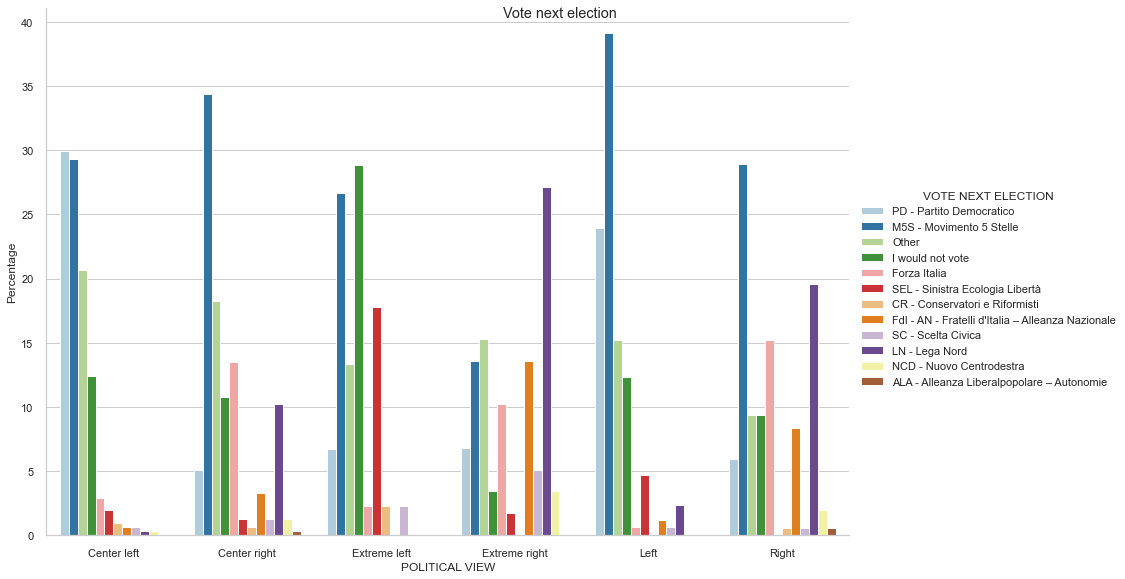

In [661]:
count = (
    data[['POLITICAL VIEW', 'VOTE NEXT ELECTION']][data['COUNTRY CODE'] == 'IT'].groupby('POLITICAL VIEW')['VOTE NEXT ELECTION']
         .value_counts(normalize=True)
         .rename('Percentage').mul(100).reset_index()
)
count['VOTE NEXT ELECTION'] = count['VOTE NEXT ELECTION'].astype(str)
f = sns.catplot(x='POLITICAL VIEW', y='Percentage', data=count, hue='VOTE NEXT ELECTION', height=8, aspect=1.5, kind='bar', 
                palette='Paired')
f.fig.suptitle('Vote next election')
print('Numero features: %s' % len(count['VOTE NEXT ELECTION'].unique()))
plt.show()

Come prevedibile la preferenza politica ha influenza sui partiti che verranno votati, anche se ci sono partiti come il Movimento 5 Stelle che hanno un'alta preferenza a prescindere dalla preferenza politica e questo influisce sul valore dell'indice U in quanto non è possibile prevedere con certezza l'orientamento politico di una persona che ha votato questo partito. Stesso discorso vale per chi ha indicato che non voterà o che voterà per un altro partito non in elenco.

Compariamo questo dato con la distribuzione dei partiti votati nell'ultima elezione:

Numero features: 13


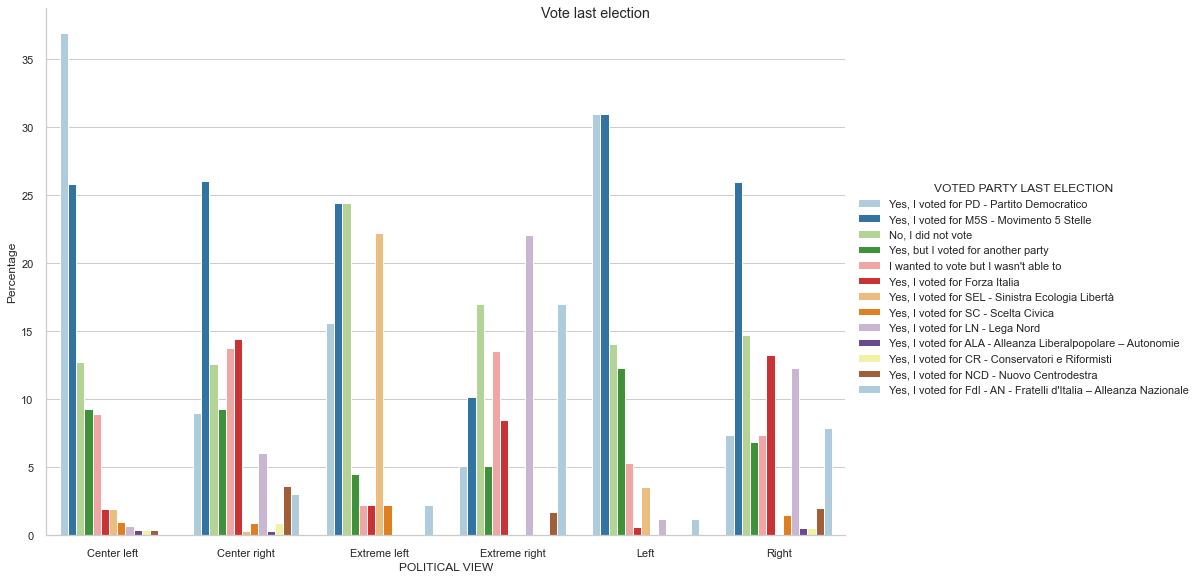

In [662]:
count2 = (
    data[['POLITICAL VIEW', 'VOTED PARTY LAST ELECTION']][data['COUNTRY CODE'] == 'IT']
    .groupby('POLITICAL VIEW')['VOTED PARTY LAST ELECTION']
    .value_counts(normalize=True)
    .rename('Percentage').mul(100).reset_index()
)
count2['VOTED PARTY LAST ELECTION'] = count2['VOTED PARTY LAST ELECTION'].astype(str)
figLast = sns.catplot(x='POLITICAL VIEW', y='Percentage', data=count2, hue='VOTED PARTY LAST ELECTION', 
                      height=8, aspect=1.5, kind='bar', palette='Paired')
figLast.fig.suptitle('Vote last election')
print('Numero features: %s' % len(data['VOTED PARTY LAST ELECTION'][data['COUNTRY CODE'] == 'IT'].unique()))
plt.show()

Notiamo come questo campo abbia una features in più rispetto al precedente, ma la distribuzione dei valori sia piuttosto simile.

Tra le varie variabili che riescono a spiegare maggiormente la preferenza politica notiamo come ve siano alcune strettamente riconducibili ad alcuni orientamenti politici come _COUNTRY COMES FIRST_ o _Less immigration_:

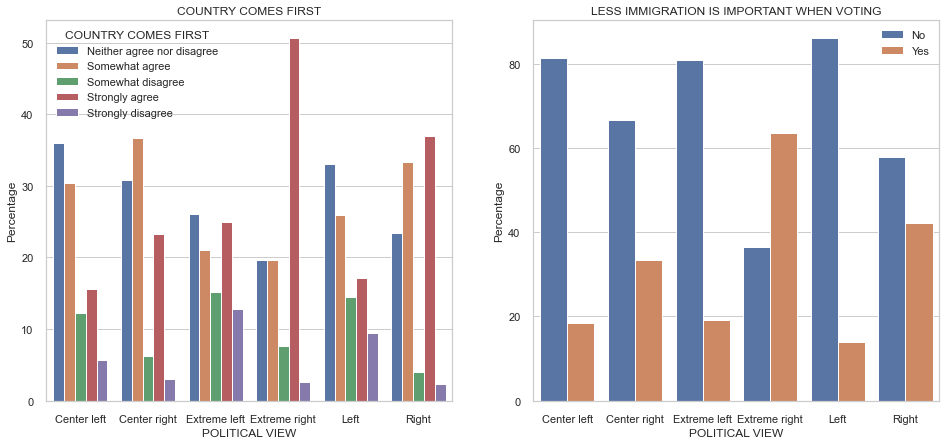

In [663]:
count = (data[['POLITICAL VIEW', 'COUNTRY COMES FIRST']].groupby('POLITICAL VIEW')['COUNTRY COMES FIRST']
         .value_counts(normalize=True).rename('Percentage').mul(100).reset_index())
fig, ax = plt.subplots(1,2, figsize=(16,7))
sns.barplot(x='POLITICAL VIEW', y='Percentage', hue='COUNTRY COMES FIRST', data=count, ax=ax[0])
ax[0].set(title="COUNTRY COMES FIRST")


count2 = (data[['POLITICAL VIEW', '[IMPORTANT ISSUES WHEN VOTING] Less immigration']]
          .groupby('POLITICAL VIEW')['[IMPORTANT ISSUES WHEN VOTING] Less immigration']
         .value_counts(normalize=True).rename('Percentage').mul(100).reset_index())
sns.barplot(x='POLITICAL VIEW', y='Percentage', hue='[IMPORTANT ISSUES WHEN VOTING] Less immigration', 
            data=count2, ax=ax[1])
ax[1].set(title="LESS IMMIGRATION IS IMPORTANT WHEN VOTING")
l = ax[1].get_legend()
l.set_title('')
for t, leg in zip(l.texts, ['No', 'Yes']): t.set_text(leg)
plt.show()

Com'era prevedibile chi ha un orientamento politico di estrema destra è molto d'accordo sul portare avanti il proprio paese rispetto agli altri e preferisce nel votare chi promette meno immigrazione. E' allo stesso modo interessante notare come però chi abbia altre preferenze politiche sia più o meno in linea nel non preferire chi promette meno immigrazione. Allo stesso modo non c'è una modalità prevalente, per gli altri orientamenti politici, relativamente all'opinione sul dare più importanza al proprio paese rispetto agli altri. Infatti, a parte chi ha orientamenti politici di destra, gli altri si trovano generalmente in accordo o comunque restano indifferenti sull'argomento.

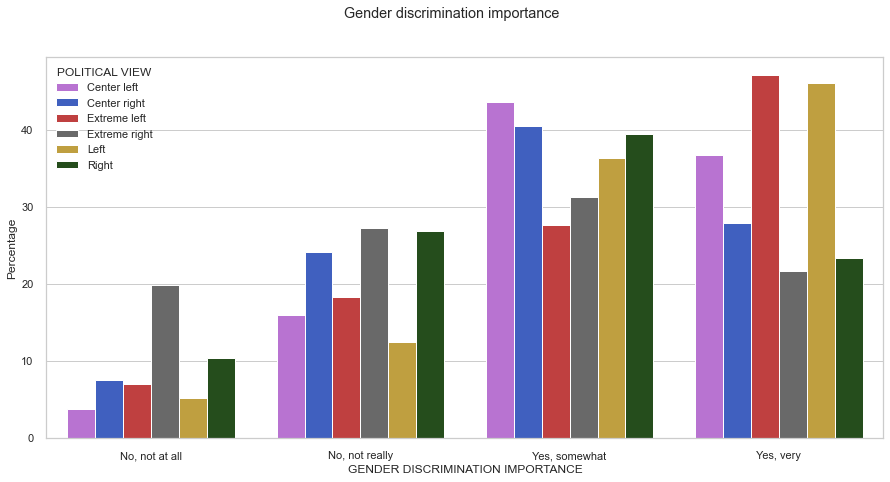

In [664]:
count = (
    data[['POLITICAL VIEW', 'GENDER DISCRIMINATION IMPORTANCE']]
    .groupby(['POLITICAL VIEW'])['GENDER DISCRIMINATION IMPORTANCE'].value_counts(normalize=True)
    .mul(100)
    .rename('Percentage')
    .reset_index()
        )

plt.figure(figsize=(15,7))
f = sns.barplot(x='GENDER DISCRIMINATION IMPORTANCE', y='Percentage', hue='POLITICAL VIEW', data=count, 
                palette=colorsMap, saturation=0.5)
plt.suptitle('Gender discrimination importance')

plt.show()

## Predizione orientamento politico

Il nostro obiettivo è ora quello di predirre l'orientamento politico di un individuo a partire da alcune sue caratteristiche utilizzando diversi modelli di Supervised ed Unsupervised Learning. In particolare i modelli che verranno utilizzati sono il _K-Means Clustering_ per il learning non supervisionato ed i modelli _SVM_ e _Neural Networks_ per il learning supervisionato.
Utilizzeremo due insieme di features per addestrare questi modelli: il primo sarà costituito dal One Hot Encoding delle prime 15 features con l'indice _U di Theil_ più alto, mentre il secondo sarà costituito dalle 15 variabili selezionate dal modello _Select K Best_ applicando la funzione _chi2_ sul One Hot Encoding dell'intero dataset. Il test _chi2_ viene utilizzato per analizzare la correlazione tra due variabili, nel nostro caso la correlazione sarà tra le varie feature del dataset e la nostra variabile target.

Al termine valuteremo le performance dei modelli in base a:

- Correttezza dei risultati
- Tempo impiegato per il training ed il testing

Le valutazioni verranno effettuate sia nel singolo modello comparando i due insiemi di features descritti in precedenza, sia tra i vari modelli tramite diversi indicatori.

### Preprocessing dei dati

In [665]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Prima di procedere all'applicazione dei modelli dobbiamo trasformare le variabili da categoriche a numeriche così da essere in grado successivamente di applicare questi algoritmi. Per le feature applichiamo il One-Hot Encoding, mentre per la variabile target utilizzeremo il LabelEncoder, che associa una label numerica ad ogni categoria.

Inizialmente creiamo il primo insieme di features che sarà composto dalle prime quindici variabili con l'indice _U di Theil_ più alto:

In [666]:
features = theilu.melt().sort_values(by='value', ascending=False).iloc[1:16]['variable']
features

59                                 VOTE NEXT ELECTION
58                          VOTED PARTY LAST ELECTION
0                                        COUNTRY CODE
49                                COUNTRY COMES FIRST
68    [IMPORTANT ISSUES WHEN VOTING] Less immigration
54                      PERCEIVED EFFECT OF DIVERSITY
57                                          WORLDVIEW
33                          LIKELIHOOD TO DEMONSTRATE
30                                         OPINION EU
55                   GENDER DISCRIMINATION IMPORTANCE
31                                 OPINION GOVERNMENT
11                                           RELIGION
26                                MEMBER ORGANIZATION
1                                                 AGE
22                            STATUS NATIONAL ECONOMY
Name: variable, dtype: object

In [667]:
X1 = data[features]
enc = OneHotEncoder(sparse=False, dtype='int')
X1 = enc.fit_transform(X1)
X1.shape

(7272, 240)

Come possiamo osservare, il _One Hot Encoding_ ha generato 240 nuove features corrispondenti alle varie modalità delle variabili precedenti. Il vantaggio di questo approccio è che conosciamo le variabili originarie utilizzate dai modelli, quindi saremo in grado di trarre conclusioni più accurate.

Effettuiamo ora l'encoding della variabile target:

In [668]:
Y = data['POLITICAL VIEW']
le = LabelEncoder()
Y = le.fit_transform(Y)
Y

array([2, 0, 0, ..., 4, 4, 0])

In [669]:
le.classes_

array(['Center left', 'Center right', 'Extreme left', 'Extreme right',
       'Left', 'Right'], dtype=object)

In questo caso il _Label Encoder_ ha associato un intero ad ogni modalità della variabile target, lasciando inalterata la sua dimensione.

Ora creiamo il secondo insieme di features selezionando le prime variabili utilizzando il test _chi2_. In questo caso applichiamo in primo luogo il _One Hot Encoding_ sull'intero insieme di features e successivamente applichiamo la funzione _Select K Best_ selezionando le 10 variabili più significative:

In [670]:
enc = OneHotEncoder(sparse=False, dtype='int')
X = enc.fit_transform(data.drop('POLITICAL VIEW', axis=1))
selector = SelectKBest(chi2, k=10)
X2 = selector.fit_transform(X, Y)
X2.shape

(7272, 10)

Notiamo come in questo caso le features che useremo per addestrare i modelli sono esattamente 10, ma dal momento che sono una selezione delle variabili generate dal _OHT_ delle variabili originarie non siamo in grado di risalire al loro significato originario.  

### Unsupervised: Classificazione dati tramite K-Means Clustering 

Il primo modello che applichiamo è il _K-Means Clustering_: questo modello di Unsupervised Learning cerca di classificare le varie features in _K_ clusters associando ad ogni campione la label del campione a lui più vicino. Nel nostro caso _K_ sarà uguale a 6, corrispondente alle diverse modalità della nostra variabile target, così da vedere se il modello è in grado autonomamente di classificare i campioni in orientamenti politici solo osservando alcune loro caratteristiche.

Per la validazione di questo modello utilizzeremo il _Silhouette Score_ corrispondente alla media dei _Silhouette Score_ per ogni singolo campione. 

Il _Silhouette Score_ è una valutazione dell'aggregazione dei vari cluster definito come:

$$
s = \frac{b-a}{\max{(a,b)}}
$$

Dove:
- a: è la distanza media tra un campione e gli altri campioni nello stesso cluster
- b: è la distanza media tra un campione e gli altri campioni appartenenti al cluster più vicino

Può assumere valori tra -1 ed 1 dove:
- 1 indica un insieme di cluster ben definiti
- 0 indica cluster sovrapposti
- -1 indica cluster non corretti


In [444]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

> **Modello su primo features set**

Silhouette score: 0.039684


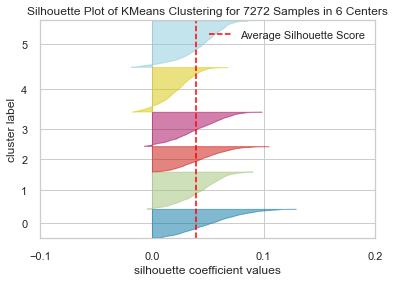

Wall time: 2.94 s


In [445]:
%%time
model = KMeans(6)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X1)
print("Silhouette score: %f" % visualizer.silhouette_score_)
visualizer.show()
plt.show()

Osserviamo come in questo caso il _Silhouette Score_ sia quasi prossimo allo zero, questo indica campioni non ben classificati, ma sovrapposti. Il modello ha impiegato 2.5 secondi per calcolare il risultato.

> **Modello su secondo features set**

Silhouette score: 0.593475


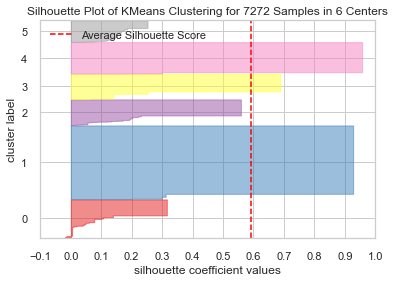

Wall time: 3.93 s


In [480]:
%%time
model = KMeans(6)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(X2)
print("Silhouette score: %f" % visualizer.silhouette_score_)
visualizer.show()
plt.show()

In questo caso il  _Silhouette Score_ ha un valore pari a 0.6, questo indica cluster migliori rispetto al caso precedente, ma comunque sempre non perfettamente definiti. Il modello ha impiegato circa 4 secondi a restituire il risultato.

In generale possiamo dire come in entrambi i casi il modello non sia in grado di classificare perfettamente i campioni osservando solamente alcune loro caratteristiche, ma l'insieme di features X2 riesce maggiormente a spiegare alcuni fenomeni del campione così da generare una classificazione più definita.

### Supervised: Support Vector Machines

Passando ora al Supervised Learning, il primo modello che utilizzeremo sono le _Support Vector Machines_: questo modello prevede la classificazione dei campioni tramite la definizione di un discriminatore in grado di separare i dati in varie classi e che abbia distanza massima tra i dati. 

Questo modello prevede una serie di iperparametri per la definizione della funzione che descrive il discriminatore, quindi per la scelta di quelli ottimali utilizziamo il modello _Grid Search_ che effettuerà una valutazione delle performance di modelli definiti con le loro varie combinazioni tramite _Cross Validation_ e restituirà la combinazione migliore. 

In particolare le possibili combinazioni sono:

- Kernel lineare e grado di tolleranza compreso nell'insieme [0.1, 1.0, 20.0, 100.0]
- Kernel polinomiale con grado di tolleranza compreso nell'insieme [0.1, 1.0, 20.0, 100.0], grado del polinomio compreso nell'intervallo (1, 10) ed indice gamma calcolato come $\frac{1}{(N * \text{var(X)})}$ o $\frac{1}{N}$
- Kernel rbf o sigmoidale con grado di tolleranza compreso nell'insieme [0.1, 1.0, 20.0, 100.0] ed indice gamma calcolato come $\frac{1}{(N * \text{var(X)})}$ o $\frac{1}{N}$


In [447]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [462]:
# Funzioni per la valutazione dei modelli

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def evaluate(model, x, y, classes, cv=5, n_jobs=-1):
    score = cross_val_score(model, x, y, cv=cv, n_jobs=n_jobs)
    pred = model.predict(x)
    ax = plot_confusion_matrix(y, pred, classes, normalize=True)
    print("Validation score: %f" % np.mean(score))
    plt.show()

> **Modello su primo features set**
>
>**NB:** Per ridurre il tempo di training altrimenti troppo alto scegliamo di utilizzare solo un sottoinsieme di X1 per la fase di addestramento tramite la funzione _Train Test Split_, in particolare per il training useremo il 40% dei campioni totali, mentre per il testing useremo il restante 60% ricampionato tramite _Cross Validation_.

In [449]:
X1_train, X1_test, Y_train, Y_test = train_test_split(X1, Y, train_size = 0.4)
param_grid = [
    {
        'C': [0.1, 1.0, 20.0, 100.0],
        'kernel': ['linear']
    },
    {
        'C': [0.1, 1.0, 20.0, 100.0],
        'kernel': ['poly'],
        'degree': np.arange(1, 10),
        'gamma': ['scale', 'auto'],
    },
    {
        'C': [0.1, 1.0, 20.0, 100.0],
        'kernel': ['rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'],
    }
]

In [450]:
%%time
model = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
model.fit(X1_train, Y_train)
model.best_params_

Wall time: 7min 22s


{'C': 1.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

Il modello ha impiegato circa 7 minuti per l'addestramento ed ha selezionato una funzione con kernel polinomiale di secondo grado, valore di tolleranza pari ad 1 e gamma calcolato tramite _scaling_ quindi pari a: $$\frac{1}{(N * \text{var(X)})}$$

Validation score: 0.458985


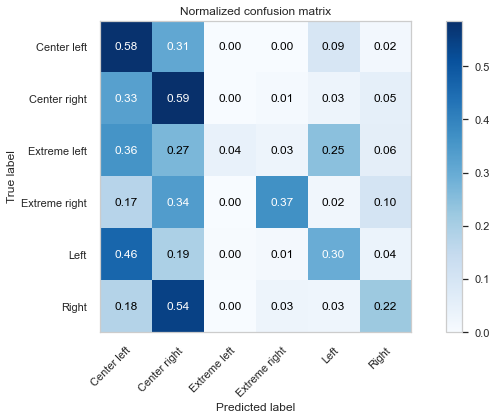

In [463]:
evaluate(model.best_estimator_, X1_test, Y_test, le.classes_)

Notiamo come in questo caso il modello non sia perfettamente in grado di distinguere le varie appartenenze politiche di un individuo, in particolare possiamo notare dalla confusion matrix come il modello faccia fatica a distinguere tra preferenze di centro, radicali ed estremiste.

> **Modello su secondo features set**

In [671]:
%%time
X2_train, X2_test, Y_train, Y_test = train_test_split(X2, Y, train_size = 0.4)
model = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
model.fit(X2_train, Y_train)
model.best_params_

Wall time: 39.9 s


{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

In questo caso il modello ha impiegato circa 40 secondi per il training ed ha selezionato un kernel rbf, con coefficiente di tolleranza pari ad 1 e gamma calcolato tramite scaling.

Validation score: 0.382904


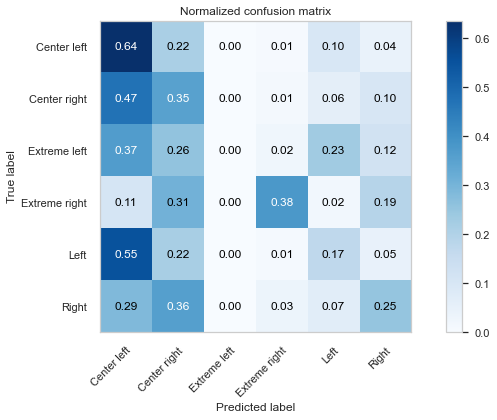

In [672]:
evaluate(model.best_estimator_, X2_test, Y_test, le.classes_)

Anche in questo caso notiamo come il modello faccia molta difficoltà ad individuare i vari orientamenti politici. In particolare in entrambi i casi notiamo come il modello tenda spesso a classificare un individuo come di centro destra o centro sinistra tralasciando gli altri orientamenti. 

Questo fenomeno può essere causato da una disomogeneità dei campioni all'interno del dataset, infatti più del 60% degli intervistati ha dichiarato di essere di centro destra o centro sinistra, determinando una bassa probabilità di incontrare individui di altri orientamenti durante le fasi di training e testing. E' importante notare come però solo in alcuni casi (come ad esempio negli individui con orientamento di estrema sinistra che sono molto bassi nel campione) il modello classifichi un individuo di destra come di sinistra o vice versa.

#### Test classificazione binaria

Per ovviare alla diversa distribuzione delle modalità della variabile target all'interno del dataset apportiamo una modifica alla $Y$ rendendola da multi label a binaria. In particolare classifichiamo gli individui di Centro sinistra ed Estrema sinistra come di Sinistra e gli individui di Centro ed Estrema destra come di Destra:

In [673]:
Y_bin = data['POLITICAL VIEW']
Y_bin[(Y_bin == 'Extreme right') | (Y_bin == 'Right') | (Y_bin == 'Center right')] = 'Right'
Y_bin[(Y_bin == 'Extreme left') | (Y_bin == 'Left') | (Y_bin == 'Center left')] = 'Left'
Y_bin = le.fit_transform(Y_bin)
np.unique(Y_bin)

array([0, 1])

In questo modo ora i modelli dovranno effettuare una classificazione binaria tra individui di Destra ed individui di Sinistra.

> **Training su primo feature set**

In [473]:
%%time
X1_train, X1_test, Y_train, Y_test = train_test_split(X1, Y_bin, train_size = 0.4)
model = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
model.fit(X1_train, Y_train)
model.best_params_

Wall time: 5min 38s


{'C': 20.0, 'gamma': 'auto', 'kernel': 'sigmoid'}

In questo caso il modello ha impiegato circa 5 minuti per il training ed ha selezionato un kernel sigmoidale con coefficiente di tolleranza pari a 20 e gamma calcolato come $\frac{1}{N}$

Validation score: 0.705542


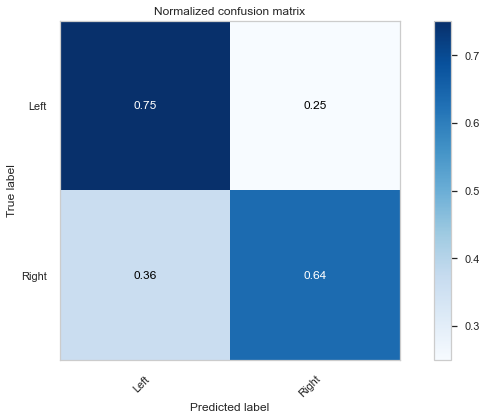

In [475]:
evaluate(model.best_estimator_, X1_test, Y_test, le.classes_)

Notiamo come le performance del modello siano salite e come ora sia in grado di classificare con più certezza l'appartenenza politica di un individuo. Il modello non è comunque privo di errori e presenta ancora diversi falsi positivi e falsi negativi che possono essere causati da un numero di features o una dimensione del campione errati.

> **Training su secondo feature set**

In [674]:
%%time
X2_train, X2_test, Y_train, Y_test = train_test_split(X2, Y_bin, train_size = 0.4)
model = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
model.fit(X2_train, Y_train)
model.best_params_

Wall time: 22.1 s


{'C': 1.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}

In questo caso il modello selezionato ha un kernel polinomiale di secondo grado, con un valore di tolleranza pari ad 1 ed un gamma calcolato tramite scaling. Il modello ha impiegato circa 20 secondi per il training.

Validation score: 0.645285


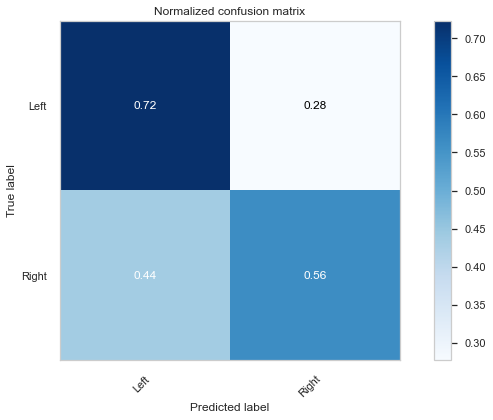

In [675]:
evaluate(model.best_estimator_, X2_test, Y_test, le.classes_)

In questo caso notiamo come il modello faccia più difficoltà a classificare l'orientamento politico di un individuo. In particolare è molto elevato il numero di falsi positivi, ad indicare come il modello tenda maggiormente a classificare una persona come di sinistra.

Quindi in generale possiamo dire come sia per la classificazione multi label che per la classificazione binaria il features set _X1_ sia maggiormente informativo e riesca ad addestrare meglio il modello.

### Supervised: Neural Networks

In [676]:
from sklearn.neural_network import MLPClassifier

In [677]:
param_grid = 

array([2, 0, 0, ..., 4, 4, 0])